In [390]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.api.types import is_numeric_dtype

In [391]:
!pip install tensorflow

In [392]:
import tensorflow as tf

In [393]:
!pip install keras

In [394]:
!pip install scikeras

In [395]:
import keras
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [396]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [397]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [398]:
!pip install shap
import shap

In [399]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [400]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [401]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [402]:
data_analysis_folder_path = '../'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [403]:
project_id = "master-thesis-2023-393813" # Fill project id
bqclient = bigquery.Client(project_id)

## Loading data

In [404]:
dataset_name = "twitbot_22_preprocessed_common_users_ids" #"twitbot_22_preprocessed"
users_table_name = "users"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
table_id = project_id + "." + BQ_TABLE_USERS

In [405]:
job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=True
)

In [406]:
# SQL_QUERY = f"""SELECT * FROM {BQ_TABLE_USERS} LIMIT 5000"""
# users_df1 = bqclient.query(SQL_QUERY).to_dataframe()

In [407]:
SQL_QUERY = f"""WITH 
  human_records AS (
    SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'human' 
    LIMIT 2500),
  bot_records AS (
  SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'bot' 
    LIMIT 2500)
  SELECT * FROM human_records 
    UNION ALL SELECT * 
    FROM bot_records 
    ORDER BY row_num;"""

users_df1 = bqclient.query(SQL_QUERY).to_dataframe()
users_df1 = users_df1.drop(['row_num'], axis=1)

In [408]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [409]:
num_bots = len(users_df1.loc[users_df1['label']=='bot'])       # bots number
num_humans = len(users_df1.loc[users_df1['label']=='human'])   # humans number

print("Number of real users: ", num_humans)
print("Number of bots: ", num_bots)

Number of real users:  2500
Number of bots:  2500


In [410]:
org_users_df = pd.DataFrame(users_df1).copy()
users_df2 = pd.DataFrame(org_users_df).copy()

#### Filter to have same number of record for each class - part I (second part after data analysis and reducing some of outliers)

In [411]:
def filter_df_for_balanced_classes(df, bot_label_value='bot', human_label_value='human'):
    new_df = pd.DataFrame()

    i = 0 # bots iter.
    j = 0 # humans iter.
    k = 0
    num_bots = len(df.loc[df['label']==bot_label_value])
    num_humans = len(df.loc[df['label']==human_label_value])
    max_num = min(num_bots, num_humans)
    for index, record in df.iterrows():
      if k < (2*max_num):
        if record['label']==bot_label_value and i < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          i += 1
          k += 1
        if record['label']==human_label_value and j < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          j += 1
          k += 1
            
    print("Number of bots: ", len(new_df.loc[new_df['label']==bot_label_value]))
    print("Number of human users: ", len(new_df.loc[new_df['label']==human_label_value]))
    
    return pd.DataFrame(new_df).copy();

In [412]:
users_df = filter_df_for_balanced_classes(users_df2)

Number of bots:  2500
Number of human users:  2500


## Data preparation

In [413]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

In [414]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

#### Align values for bool columns

In [415]:
boolean_columns = ["verified", "protected", "withheld", "has_location", "has_profile_image_url", "has_pinned_tweet", "has_description"]

In [416]:
# Firstly align boolean columns values
for col_name in boolean_columns:
    users_df[col_name] = users_df[col_name].astype(bool)

column_to_remove = []
# Check unique values (some of subset can have only one unique value for some feature) if so it column will be removed from dataframe
for col_name in boolean_columns:
    uniq_val_list = users_df[col_name].unique()
    print("Column {:<24} {}".format(col_name, str(uniq_val_list)))
    if (len(uniq_val_list) < 2):
        column_to_remove.append(col_name)

Column verified                 [False  True]
Column protected                [False  True]
Column withheld                 [False]
Column has_location             [ True False]
Column has_profile_image_url    [ True False]
Column has_pinned_tweet         [False  True]
Column has_description          [ True False]


In [417]:
column_to_remove

['withheld']

In [418]:
# remove from bool columns:
for col_name in column_to_remove:
    boolean_columns.remove(col_name)
# remove from dataframe
users_df = drop_columns(users_df, column_to_remove)

### Encoding of non-numeric information which will be used by model

In [419]:
# Remap the values of the dataframe
for col_name in boolean_columns:
  users_df[col_name] = users_df[col_name].map({True:1,False:0})

# Remap label values human/bot for 0/1
label_col = "label"
users_df[label_col] = users_df[label_col].map({"human":0,"bot":1})


In [420]:
users_df

id  label         username  \
0     1428769922507751429      1  BotoxAesthetics   
1     1484544053572419585      0  blessing_xettry   
2      842202106324951040      1     Mark11474609   
3     1447956502443069446      0      menametaken   
4                21309002      1          Sjouzan   
...                   ...    ...              ...   
4995           1012071950      0      aoifeglynn1   
4996   749993073795559424      1     explorersedu   
4997             42145896      0    NYBloodCenter   
4998            215191174      1      anonjdmking   
4999             19248487      0         bmograph   

                                name    created_at  verified  protected  \
0     dermalfillers Aesthetics botox  1.629480e+09         0          0   
1                   #Blessing xettry  1.642778e+09         0          0   
2                               Mark  1.489632e+09         0          0   
3                          winwinnie  1.634055e+09         0          0   
4                             Zuzana  1.235058e+09         0          0   
...                              ...           ...       ...        ...   
4995                           Aoife  1.355523e+09         0          0   
4996   Explorers Education Programme  1.467647e+09         0          0   
4997                 NY Blood Center  1.243132e+09         1          0   
4998                              BB  1.289632e+09         0          0   
4999                   Brian Morrice  1.232475e+09         0          0   

      has_location                  location  has_profile_image_url  \
0                1   London , United Kingdom                      1   
1                1                     Nepal                      1   
2                1    Kelvin Grove, Brisbane                      1   
3                1                your walls                      1   
4                1              Brighton, UK                      1   
...            ...                       ...                    ...   
4995             1                   Ireland                      1   
4996             0                      None                      1   
4997             1     New York, New Jersey                       1   
4998             0                      None                      1   
4999             1  Scotland, United Kingdom                      1   

      has_pinned_tweet                      url  followers_count  \
0                    0  https://t.co/CBDBvXnRKv              2.0   
1                    0                                       0.0   
2                    0                                       3.0   
3                    0                                       0.0   
4                    0                                       3.0   
...                ...                      ...              ...   
4995                 0                                     552.0   
4996                 0                                     800.0   
4997                 0  https://t.co/jGBu06m0l1           5160.0   
4998                 0                                      34.0   
4999                 0  https://t.co/AM0k24MdmO            553.0   

      following_count  tweet_count  listed_count  has_description  \
0                41.0          1.0           0.0                1   
1                24.0          1.0           0.0                1   
2                22.0          4.0           0.0                0   
3                20.0          1.0           0.0                1   
4                42.0          2.0           0.0                0   
...               ...          ...           ...              ...   
4995            520.0       2783.0           2.0                1   
4996            375.0       2053.0           4.0                0   
4997            815.0       8251.0          93.0                1   
4998            123.0          9.0           0.0                0   
4999            613.0       8481.0          41.0        

#### Null and NaN statistics

In [421]:
for col_name in users_df:
    count1 = pd.isnull(users_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
label: 0
username: 0
name: 0
created_at: 0
verified: 0
protected: 0
has_location: 0
location: 1729
has_profile_image_url: 0
has_pinned_tweet: 0
url: 0
followers_count: 0
following_count: 0
tweet_count: 0
listed_count: 0
has_description: 0
description: 0
descr_no_hashtags: 0
descr_no_cashtags: 0
descr_no_mentions: 0
descr_no_urls: 0
url_no_urls: 0


#### Extract some information from dataframe to new columns

##### Description length

In [422]:
users_df['descr_len'] = users_df['description'].apply(len).astype(float)

##### Account age (in days) (sice 16.03.2022) (dataset data collected during the 20/01-15/03/2022 period)

In [423]:
from datetime import datetime

In [424]:
def cal_days_diff(a,b):
    A = a.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    B = b.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    return (A - B).days

def convert_unixtime_to_datetime(a):
    return datetime.utcfromtimestamp(a)

In [425]:
base_date = datetime(2022, 3, 16)
users_df['account_age'] = users_df.apply(lambda x: cal_days_diff(base_date, convert_unixtime_to_datetime(x.created_at)), axis=1).astype(float)

#### Reduce unnecessary columns

In [426]:
users_reduced_df = pd.DataFrame(users_df).copy()
# columns_to_drop = ["id", "username", "name", "created_at", "location", "url", "description"]
columns_to_drop = ["username", "name", "created_at", "location", "url", "description"]
users_reduced_df = drop_columns(users_reduced_df, columns_to_drop)
users_reduced_df

id  label  verified  protected  has_location  \
0     1428769922507751429      1         0          0             1   
1     1484544053572419585      0         0          0             1   
2      842202106324951040      1         0          0             1   
3     1447956502443069446      0         0          0             1   
4                21309002      1         0          0             1   
...                   ...    ...       ...        ...           ...   
4995           1012071950      0         0          0             1   
4996   749993073795559424      1         0          0             0   
4997             42145896      0         1          0             1   
4998            215191174      1         0          0             0   
4999             19248487      0         0          0             1   

      has_profile_image_url  has_pinned_tweet  followers_count  \
0                         1                 0              2.0   
1                         1                 0              0.0   
2                         1                 0              3.0   
3                         1                 0              0.0   
4                         1                 0              3.0   
...                     ...               ...              ...   
4995                      1                 0            552.0   
4996                      1                 0            800.0   
4997                      1                 0           5160.0   
4998                      1                 0             34.0   
4999                      1                 0            553.0   

      following_count  tweet_count  listed_count  has_description  \
0                41.0          1.0           0.0                1   
1                24.0          1.0           0.0                1   
2                22.0          4.0           0.0                0   
3                20.0          1.0           0.0                1   
4                42.0          2.0           0.0                0   
...               ...          ...           ...              ...   
4995            520.0       2783.0           2.0                1   
4996            375.0       2053.0           4.0                0   
4997            815.0       8251.0          93.0                1   
4998            123.0          9.0           0.0                0   
4999            613.0       8481.0          41.0                1   

      descr_no_hashtags  descr_no_cashtags  descr_no_mentions  descr_no_urls  \
0                   0.0                0.0                0.0            0.0   
1                   0.0                0.0                0.0            0.0   
2                   0.0                0.0                0.0            0.0   
3                   1.0                0.0                0.0            0.0   
4                   0.0                0.0                0.0            0.0   
...                 ...                ...                ...            ...   
4995                0.0                0.0                0.0            0.0   
4996                0.0                0.0                0.0            0.0   
4997                1.0                0.0                0.0            0.0   
4998                0.0                0.0                0.0            0.0   
4999                0.0                0.0                1.0            0.0   

      url_no_urls  descr_len  account_age  
0             1.0      160.0        208.0  
1             0.0       72.0         54.0  
2             0.0        0.0       1826.0  
3             0.0       85.0        155.0  
4             0.0        0.0       4773.0  
...           ...        ...          ...  
4995          0.0       18.0       3379.0  
4996          0.0        0.0       2081.0  
4997          1.0      124.0       4679.0  
4998          0.0        0.0       4141.0  
4999          1.0      127.0       4803.0  

[5000 rows x 19 columns]

### Data type conversion (to float)

In [427]:
for (column_name, column_data) in users_reduced_df.iteritems():
    users_reduced_df[column_name] = users_reduced_df[column_name].astype(float)

### Data split for training, validation and testing

In [428]:
train_data, test_data = train_test_split(users_reduced_df, test_size=0.30, random_state=25, shuffle=True)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=25, shuffle=True)

### Create same dataframe for validation and test set to work with based on outliers analysis (done in later part)

In [429]:
val_data_wo_outliers = pd.DataFrame(val_data).copy()
test_data_wo_outliers = pd.DataFrame(test_data).copy()

### Describe trainig dataset

In [430]:
train_data.describe()

id        label     verified    protected  has_location  \
count  3.500000e+03  3500.000000  3500.000000  3500.000000   3500.000000   
mean   5.411035e+17     0.507143     0.043429     0.001429      0.656571   
std    6.045177e+17     0.500020     0.203849     0.037775      0.474921   
min    9.530000e+02     0.000000     0.000000     0.000000      0.000000   
25%    2.905216e+08     0.000000     0.000000     0.000000      0.000000   
50%    3.306997e+09     1.000000     0.000000     0.000000      1.000000   
75%    1.182558e+18     1.000000     0.000000     0.000000      1.000000   
max    1.495955e+18     1.000000     1.000000     1.000000      1.000000   

       has_profile_image_url  has_pinned_tweet  followers_count  \
count            3500.000000       3500.000000     3.500000e+03   
mean                0.999714          0.213714     6.612868e+03   
std                 0.016903          0.409986     6.748450e+04   
min                 0.000000          0.000000     0.000000e+00   
25%                 1.000000          0.000000     3.200000e+01   
50%                 1.000000          0.000000     2.795000e+02   
75%                 1.000000          0.000000     1.445750e+03   
max                 1.000000          1.000000     3.518012e+06   

       following_count    tweet_count  listed_count  has_description  \
count      3500.000000    3500.000000   3500.000000      3500.000000   
mean       1318.314857    6619.587714     82.499714         0.797429   
std        7020.981850   28200.451790    356.715336         0.401973   
min           0.000000       0.000000      0.000000         0.000000   
25%          72.000000      27.000000      0.000000         1.000000   
50%         272.000000     539.500000      3.000000         1.000000   
75%         890.250000    3148.750000     36.000000         1.000000   
max      244195.000000  559394.000000   9314.000000         1.000000   

       descr_no_hashtags  descr_no_cashtags  descr_no_mentions  descr_no_urls  \
count        3500.000000        3500.000000        3500.000000    3500.000000   
mean            0.422857           0.001429           0.348857       0.081714   
std             1.385444           0.037775           0.929195       0.325460   
min             0.000000           0.000000           0.000000       0.000000   
25%             0.000000           0.000000           0.000000       0.000000   
50%             0.000000           0.000000           0.000000       0.000000   
75%             0.000000           0.000000           0.000000       0.000000   
max            17.000000           1.000000          12.000000       4.000000   

       url_no_urls    descr_len  account_age  
count  3500.000000  3500.000000  3500.000000  
mean      0.563143    84.416286  2467.018857  
std       0.496068    59.706978  1621.390841  
min       0.000000     0.000000    22.000000  
25%       0.000000    22.000000   887.000000  
50%       1.000000    94.000000  2451.000000  
75%       1.000000   143.000000  3973.250000  
max       1.000000   243.000000  5724.000000

# Data analysis

In [431]:
def get_dataframe_real_indexes(df, outliers_index_list):
    real_all_indexes = train_data.loc[train_data['label']==1].index
    oder_indexes = np.arange(len(real_all_indexes)) 

    indexes_df = pd.DataFrame({'real_index' : real_all_indexes, 'order_index' : oder_indexes})
    return list(indexes_df[indexes_df.order_index.isin(outliers_index_list)]['real_index'])

In [432]:
def outliers_KNN(data, column_name, n_neighbors=10, radius=5, title="", r1=48, r2=90, w=900, h=500, ydtick=2, xdtick=2, nbins=20,  th = 0.9):

    np.set_printoptions(threshold=np.inf)

    # create model
    nbrs = NearestNeighbors(n_neighbors = n_neighbors, radius=radius)
    # fit model
    data_2d = [ [ 0., x] for x in data[column_name].values]
    nbrs.fit(data_2d)

    neighbors_and_distances = nbrs.kneighbors(data_2d)
    distances = neighbors_and_distances[0]
    neighbors = neighbors_and_distances[1]
    # print(neighbors_and_distances[1])

    plt.figure(figsize=(15, 7))
    # plt.plot(distances.mean(axis=1))

    distances = pd.DataFrame(distances)
    distances_mean = pd.DataFrame(distances).mean(axis =1)
    # distances_mean.describe()
    
    outliers_index = np.where(distances_mean > th) 
    outliers_index = list(outliers_index)[0]
    outliers_index = [outliers_index[i] for i in range(len(outliers_index))]
    outliers_index_with_column_name = [[indx, data[column_name].values[indx]] for indx in outliers_index]
    outliers_index_sorted_by_column_name = sorted(outliers_index_with_column_name,key=lambda x: x[1])

    outliers = list(dict(outliers_index_sorted_by_column_name).values())
    outliers_indexes = list(dict(outliers_index_sorted_by_column_name).keys())

    print("Number of outliers: ", len(outliers))

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    trace1 = go.Histogram(
            x=data[column_name],
            name=column_name,
            nbinsx=nbins,
            opacity=0.7,
    )
    trace2 = go.Histogram(
        x=outliers,
        nbinsx=nbins,
        # histnorm='density',
        name='outliers',
        opacity=0.7
    )

    traces = [trace1, trace2]
    layout = go.Layout(barmode='overlay')
    # layout = go.Layout()
    fig = go.Figure(data=traces, layout=layout)
    fig.update_layout(
        title_text=title, # title f plot
        xaxis_title_text='value', # xaxis label
        yaxis_title_text='frequency', # yaxis label
        bargap=0.05,
        bargroupgap=0.05
    )

    # fig.update_xaxes(dtick=xdtick, range =[r1,r2])
    # fig.update_yaxes(dtick=ydtick)
    fig.update_layout(
        width=w,
        height=h)
    fig.show()
    
    return get_dataframe_real_indexes(data, outliers_index)

## Distribution of label class in training, validation and test set

In [433]:
stack_data = {'Set': ['Training data', 'Validation data', 'Test data', 'Training data', 'Validation data', 'Test data'],
              'Label': ['Bot', 'Bot', 'Bot', 'Human', 'Human', 'Human'],
              'Freq': [len(train_data.loc[train_data['label']==1]), 
                       len(val_data.loc[val_data['label']==1]), 
                       len(test_data.loc[test_data['label']==1]),
                       len(train_data.loc[train_data['label']==0]), 
                       len(val_data.loc[val_data['label']==0]), 
                       len(test_data.loc[test_data['label']==0])]}
sdf = pd.DataFrame(stack_data)
sdf

Set  Label  Freq
0    Training data    Bot  1775
1  Validation data    Bot   354
2        Test data    Bot   371
3    Training data  Human  1725
4  Validation data  Human   396
5        Test data  Human   379

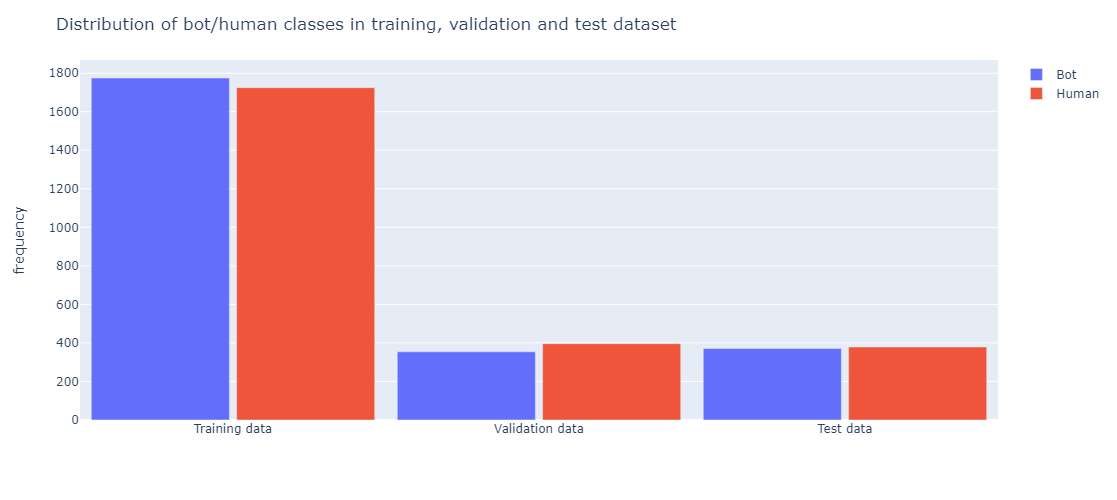

In [434]:
fig = px.bar(sdf, x="Set", y="Freq",
             color="Label", hover_data=['Label'],
             barmode = 'group')
fig.update_layout(
    title_text='Distribution of bot/human classes in training, validation and test dataset',
    xaxis_title_text='', #'subset',
    yaxis_title_text='frequency',
    bargap=0.05,
    bargroupgap=0.05,
    width=700,
    height=500,
    legend={"title":""})
fig.show()

## Distribution of other features in training dataset

### ['verified', 'protected', 'has_location', 'has_profile_image_url', 'has_pinned_tweet', 'has_description']

In [435]:
train_bot_data = train_data.loc[train_data['label']==1]
train_human_data = train_data.loc[train_data['label']==0]

stack_bool_training_feature_data = {'Feature': ['verified', 'protected', 'has_location', 'has_profile_image_url', 'has_pinned_tweet', 'has_description']*4,
    'Label': ['Bot']*12 + ['Human']*12,
    'Value': [True]*6 + [False]*6 + [True]*6 + [False]*6,
    'Freq': [len(train_bot_data.loc[train_bot_data['verified']==1]), 
             len(train_bot_data.loc[train_bot_data['protected']==1]), 
             len(train_bot_data.loc[train_bot_data['has_location']==1]),
             len(train_bot_data.loc[train_bot_data['has_profile_image_url']==1]), 
             len(train_bot_data.loc[train_bot_data['has_pinned_tweet']==1]), 
             len(train_bot_data.loc[train_bot_data['has_description']==1]),
             len(train_bot_data.loc[train_bot_data['verified']==0]), 
             len(train_bot_data.loc[train_bot_data['protected']==0]), 
             len(train_bot_data.loc[train_bot_data['has_location']==0]),
             len(train_bot_data.loc[train_bot_data['has_profile_image_url']==0]), 
             len(train_bot_data.loc[train_bot_data['has_pinned_tweet']==0]), 
             len(train_bot_data.loc[train_bot_data['has_description']==0]),
             len(train_human_data.loc[train_human_data['verified']==1]), 
             len(train_human_data.loc[train_human_data['protected']==1]), 
             len(train_human_data.loc[train_human_data['has_location']==1]),
             len(train_human_data.loc[train_human_data['has_profile_image_url']==1]), 
             len(train_human_data.loc[train_human_data['has_pinned_tweet']==1]), 
             len(train_human_data.loc[train_human_data['has_description']==1]),
             len(train_human_data.loc[train_human_data['verified']==0]), 
             len(train_human_data.loc[train_human_data['protected']==0]), 
             len(train_human_data.loc[train_human_data['has_location']==0]),
             len(train_human_data.loc[train_human_data['has_profile_image_url']==0]), 
             len(train_human_data.loc[train_human_data['has_pinned_tweet']==0]), 
             len(train_human_data.loc[train_human_data['has_description']==0])]}

stack_training_bool_feature_df = pd.DataFrame(stack_bool_training_feature_data)

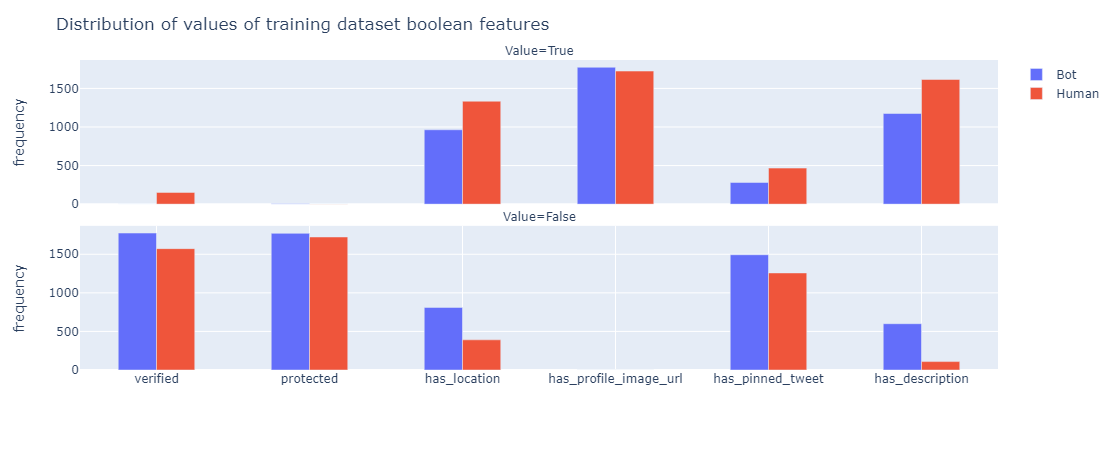

In [436]:
fig = px.bar(stack_training_bool_feature_df, 
               x="Feature", 
               y="Freq",
               facet_col="Value",
               facet_col_wrap = 1,
               color="Label", hover_data=['Label'],
               barmode = 'group')
fig.update_layout(
    title_text='Distribution of values of training dataset boolean features',
    xaxis_title_text='', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True))

fig.update_yaxes(row=2, col=1, title='frequency')
fig.show()

### followers_count

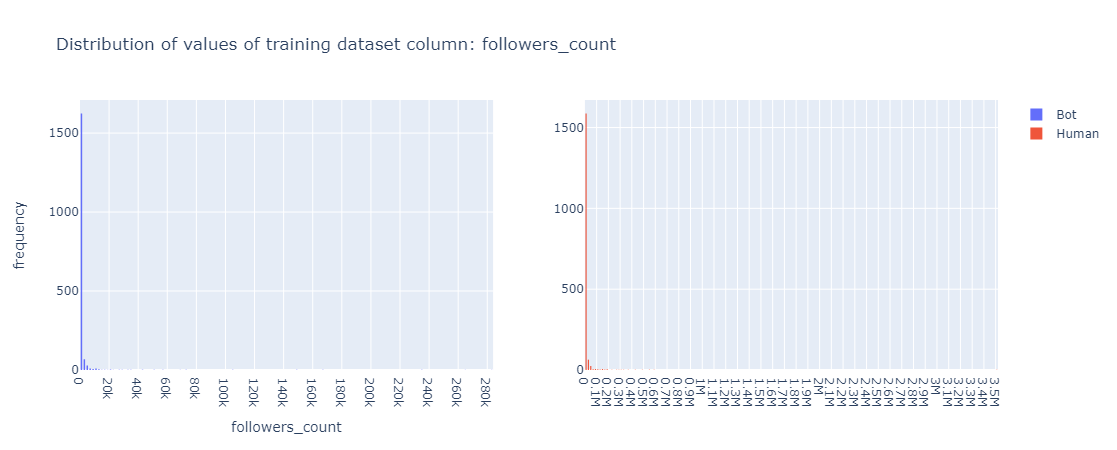

In [437]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='followers_count', dtick=20000),
    xaxis2=dict(showgrid=True, dtick=100000),
    yaxis=dict(showgrid=True))

fig.show()

#### followers_count - outliers

##### K-means (mnonot useful)

Number of outliers:  288


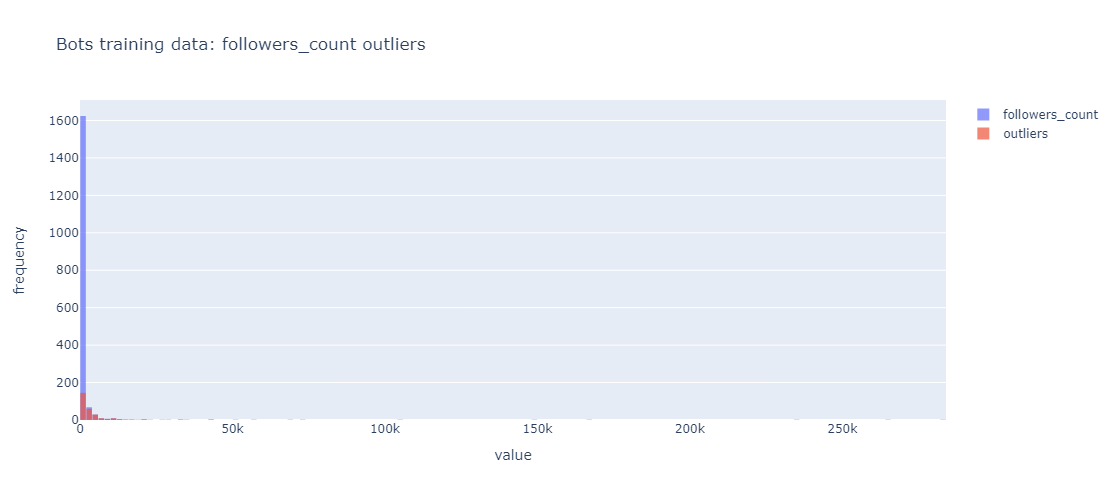

<Figure size 1500x700 with 0 Axes>

In [438]:
followers_count_bots_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==1], 'followers_count', title = "Bots training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

Number of outliers:  723


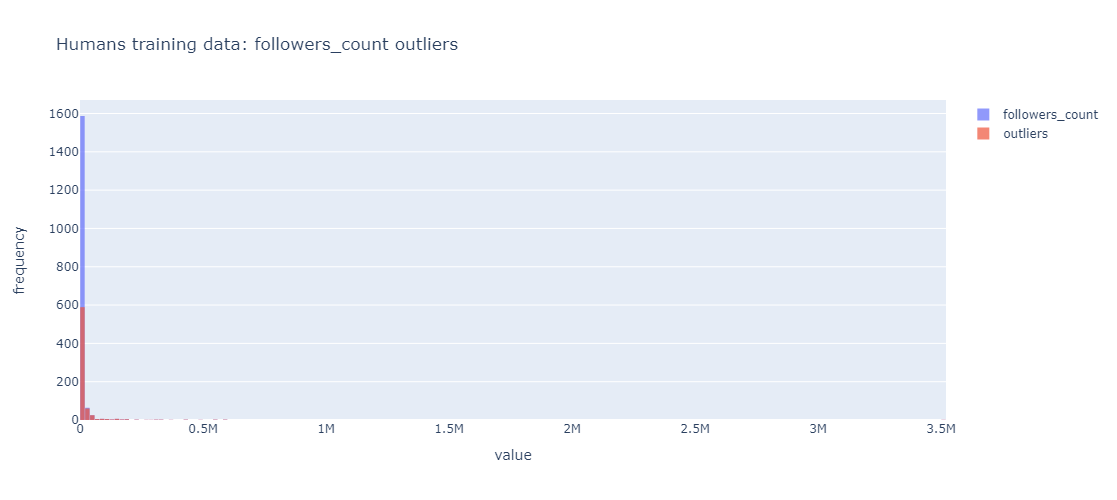

<Figure size 1500x700 with 0 Axes>

In [439]:
followers_count_humans_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==0], 'followers_count', title = "Humans training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

In [440]:
# q_hi_bots = train_data.loc[train_data['label']==1]['followers_count'].quantile(0.99, interpolation='nearest')
# q_hi_humans = train_data.loc[train_data['label']==0]['followers_count'].quantile(0.99, interpolation='nearest')

# df_filtered_bots = train_data.loc[train_data['label']==1][(train_data.loc[train_data['label']==1]['followers_count'] < q_hi_bots)]
# df_filtered_humans = train_data.loc[train_data['label']==0][(train_data.loc[train_data['label']==0]['followers_count'] < q_hi_humans)]

In [441]:
len(train_data[(train_data['label']==1)])

1775

In [442]:
len(train_data[(train_data['label']==0)])

1725

In [443]:
from scipy.stats import expon

# Fit an exponential distribution to data
loc_b, scale_b = expon.fit(train_data.loc[train_data['label']==1]['followers_count'])
loc_h, scale_h = expon.fit(train_data.loc[train_data['label']==0]['followers_count'])

# Calculate the 99th percentile using the percent-point function (inverse CDF)
percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
df_reduced_outliers_followers_count = train_data[((train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)) | ((train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans))]
df_filtered_bots = train_data[(train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)]
df_filtered_humans = train_data[(train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans)]

In [444]:
def df_99_percentile(df, column_name):
    # Fit an exponential distribution to data
    loc_b, scale_b = expon.fit(df.loc[df['label']==1][column_name])
    loc_h, scale_h = expon.fit(df.loc[df['label']==0][column_name])

    # Calculate the 99th percentile using the percent-point function (inverse CDF)
    percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
    percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
    return df[((df['label']==1) & (df[column_name] < percentile_99_bots)) | ((df['label']==0) & (df[column_name] < percentile_99_humans))]

In [445]:
len(df_filtered_bots)

1729

In [446]:
len(df_filtered_humans)

1669

In [447]:
len(df_reduced_outliers_followers_count) 

3398

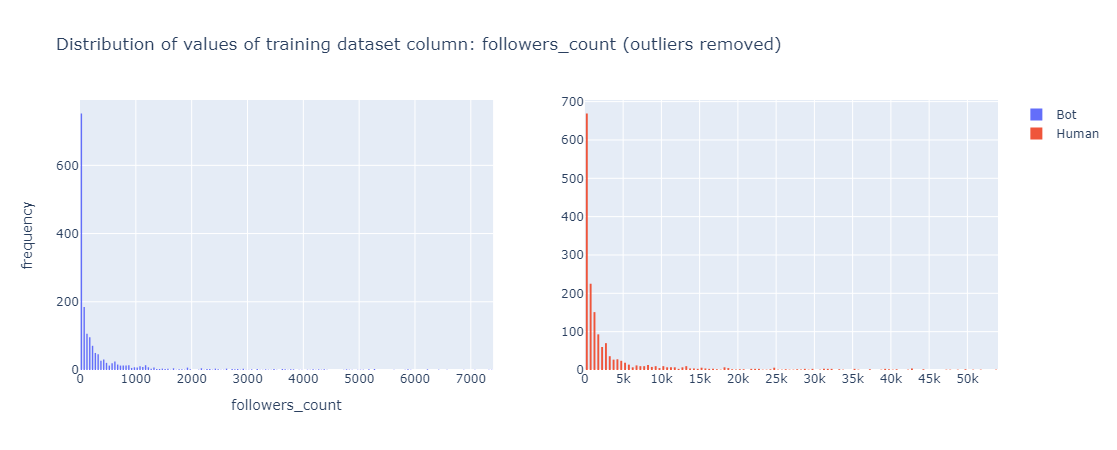

In [448]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count (outliers removed)',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000),
    xaxis2=dict(showgrid=True, dtick=5000),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count

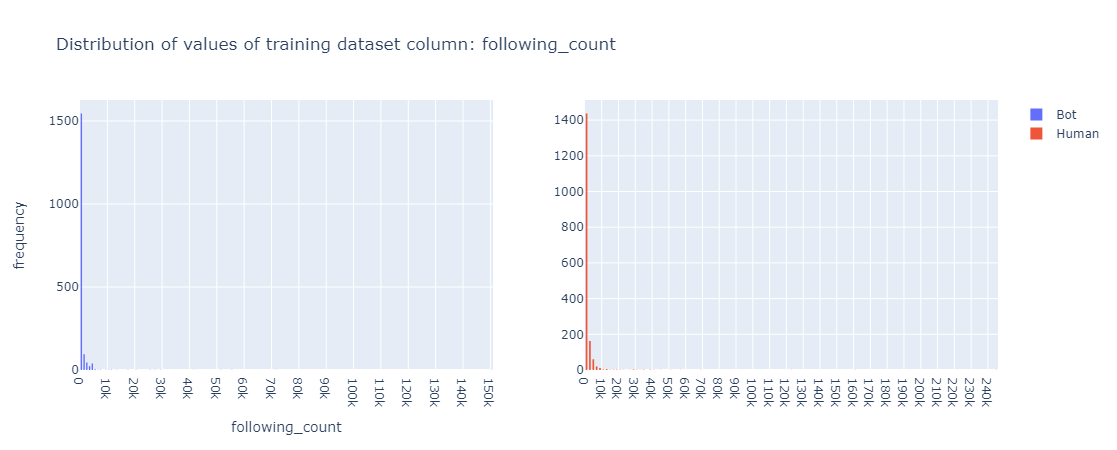

In [449]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10000),
    xaxis2=dict(showgrid=True, dtick=10000),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count - outliers

In [450]:
df_reduced_outliers_following_count = df_99_percentile(df=train_data, column_name='following_count')

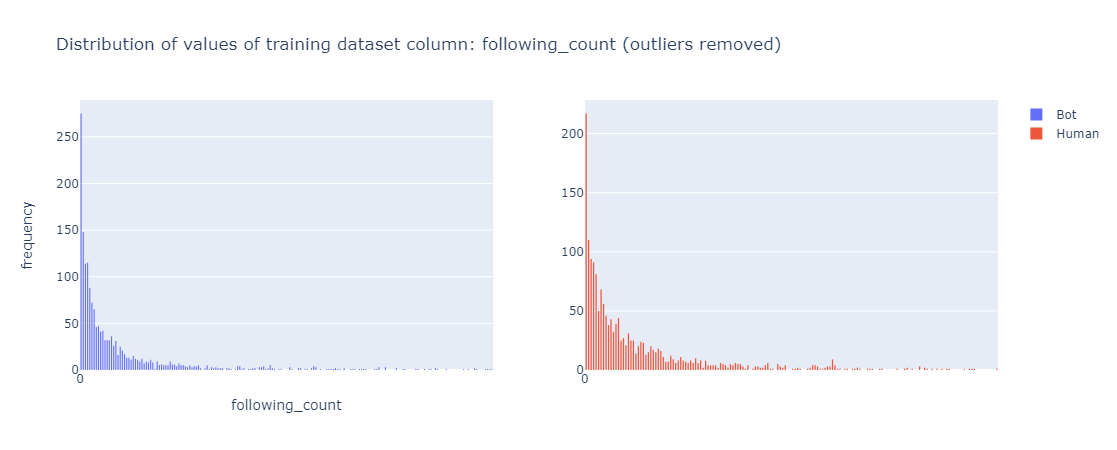

In [451]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count (outliers removed)',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10000),
    xaxis2=dict(showgrid=True, dtick=10000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count

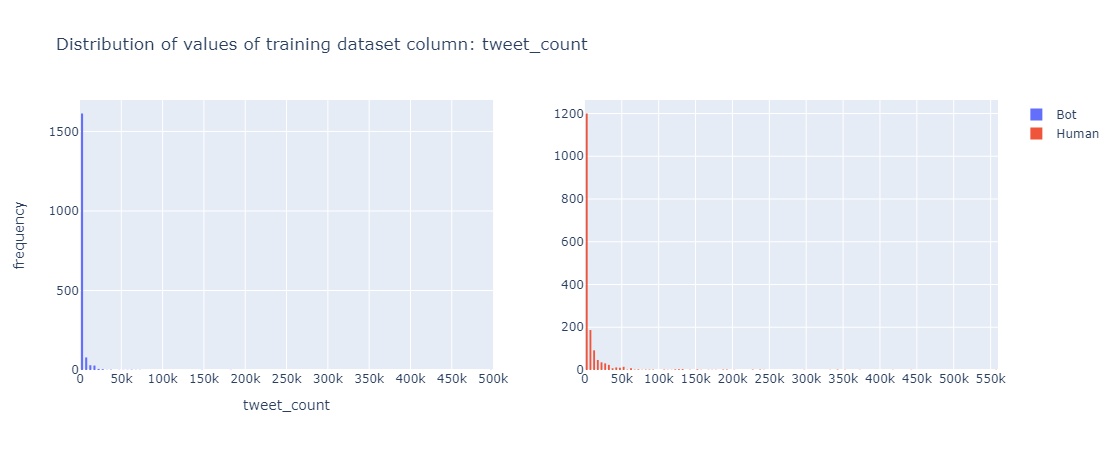

In [452]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=50000),
    xaxis2=dict(showgrid=True, dtick=50000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count - outliers

In [453]:
df_reduced_outliers_tweet_count = df_99_percentile(df=train_data, column_name='tweet_count')

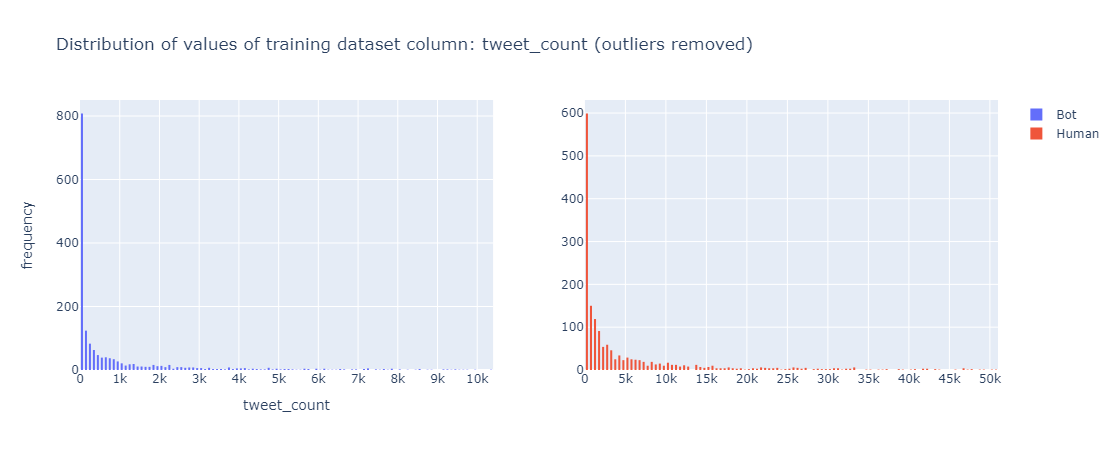

In [454]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count (outliers removed)',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000),
    xaxis2=dict(showgrid=True, dtick=5000),
    yaxis=dict(showgrid=True))

fig.show()

### listed_count

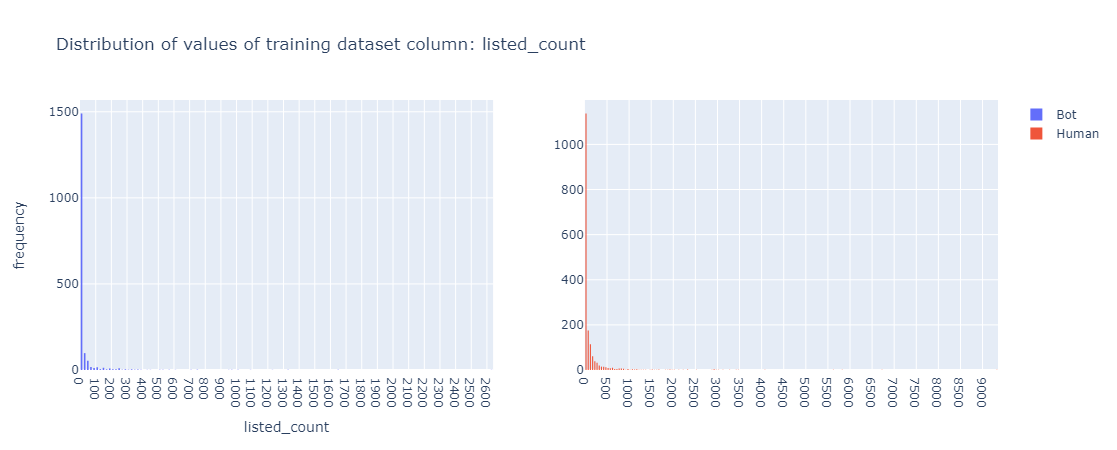

In [455]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: listed_count',
    xaxis_title_text='listed_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=100),
    xaxis2=dict(showgrid=True, dtick=500),
    yaxis=dict(showgrid=True))

fig.show()

#### listed_count - outliers

In [456]:
df_reduced_outliers_listed_count = df_99_percentile(df=train_data, column_name='listed_count')

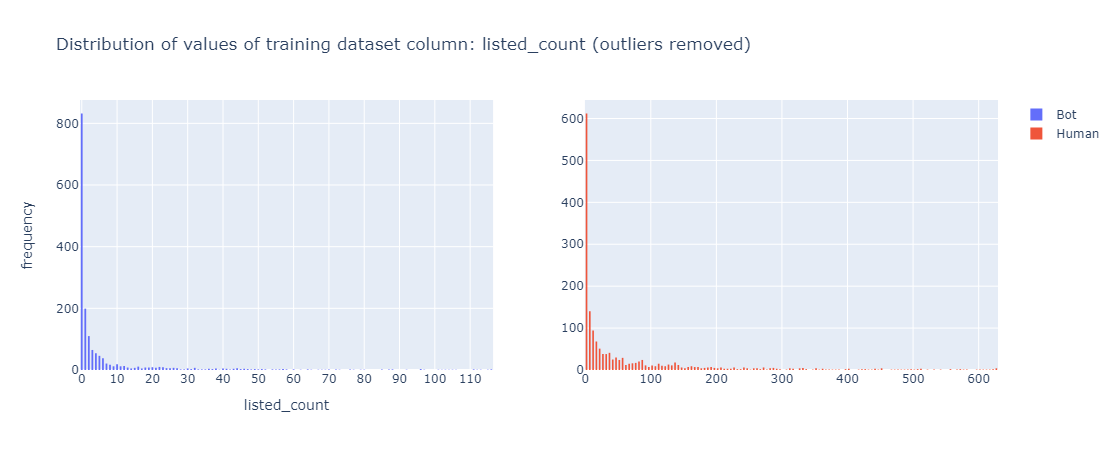

In [457]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_listed_count.loc[df_reduced_outliers_listed_count['label']==1,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_listed_count.loc[df_reduced_outliers_listed_count['label']==0,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: listed_count (outliers removed)',
    xaxis_title_text='listed_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=100),
    yaxis=dict(showgrid=True))

fig.show()

### ['descr_no_hashtags', 'descr_no_cashtags', 'descr_no_mentions', 'descr_no_urls', 'descr_len', 'url_no_urls']

### descr_no_hashtags

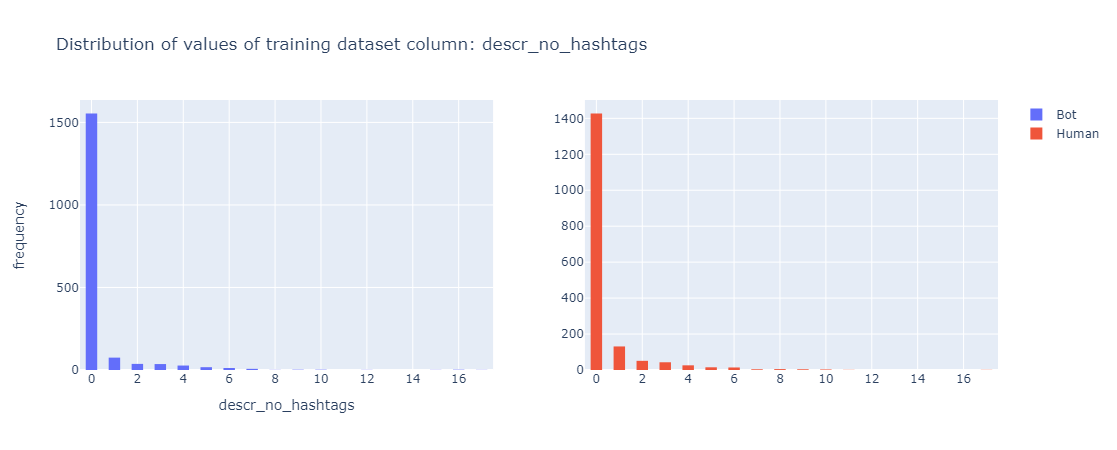

In [458]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_hashtags'],
    # histnorm='density',
    nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_hashtags'],
    # histnorm='density',
    nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_hashtags',
    xaxis_title_text='descr_no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=2),
    xaxis2=dict(showgrid=True, dtick=2),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_hashtags - outliers

In [459]:
df_reduced_outliers_descr_no_hashtags = df_99_percentile(df=train_data, column_name='descr_no_hashtags')

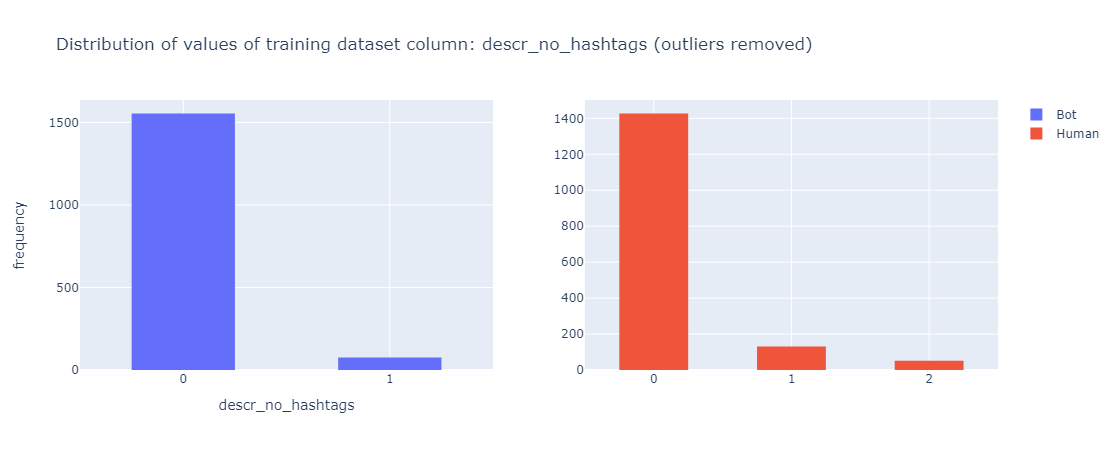

In [460]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_hashtags.loc[df_reduced_outliers_descr_no_hashtags['label']==1,'descr_no_hashtags'],
    # histnorm='density',
    # nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_hashtags.loc[df_reduced_outliers_descr_no_hashtags['label']==0,'descr_no_hashtags'],
    # histnorm='density',
    # nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_hashtags (outliers removed)',
    xaxis_title_text='descr_no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_no_cashtags


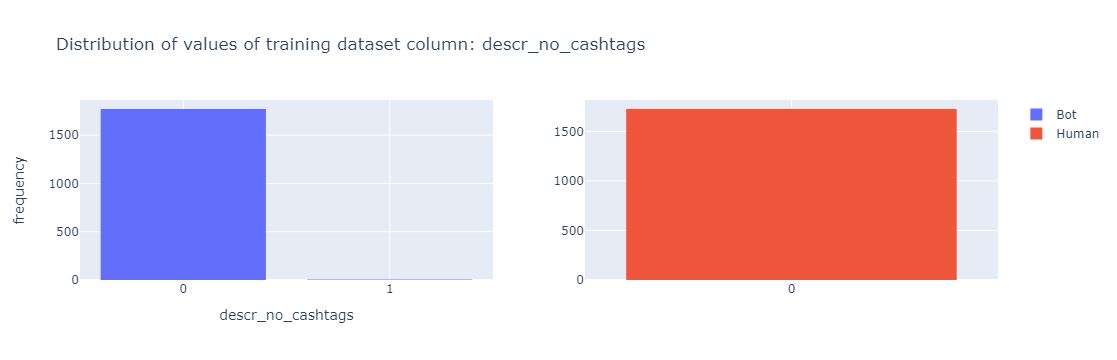

In [461]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_cashtags',
    xaxis_title_text='descr_no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_cashtags - outliers

In [462]:
df_reduced_outliers_descr_no_cashtags = df_99_percentile(df=train_data, column_name='descr_no_cashtags')

/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning:

invalid value encountered in multiply



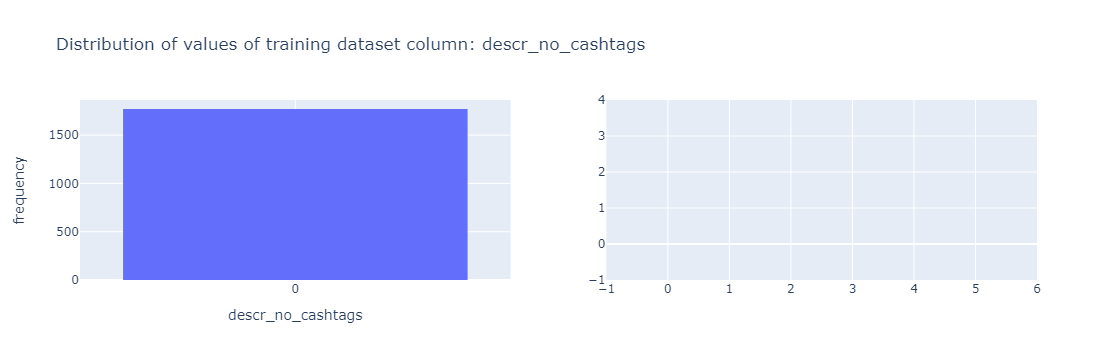

In [463]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_cashtags.loc[df_reduced_outliers_descr_no_cashtags['label']==1,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_cashtags.loc[df_reduced_outliers_descr_no_cashtags['label']==0,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_cashtags',
    xaxis_title_text='descr_no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

Better to drop this column (DONE, droped later)

### descr_no_mentions

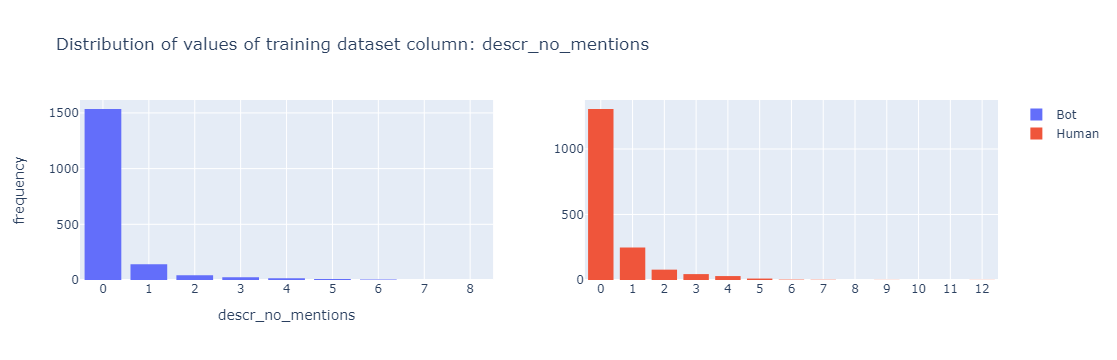

In [464]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_mentions - outliers

In [465]:
df_reduced_outliers_descr_no_mentions = df_99_percentile(df=train_data, column_name='descr_no_mentions')

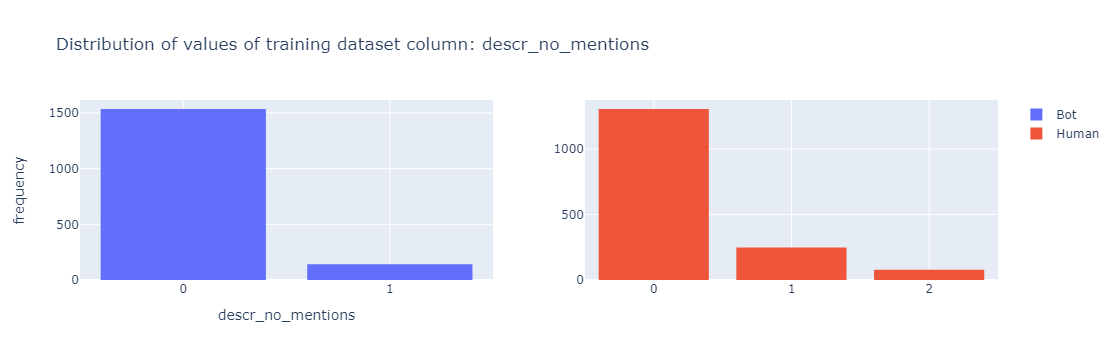

In [466]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_mentions.loc[df_reduced_outliers_descr_no_mentions['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_mentions.loc[df_reduced_outliers_descr_no_mentions['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_no_urls

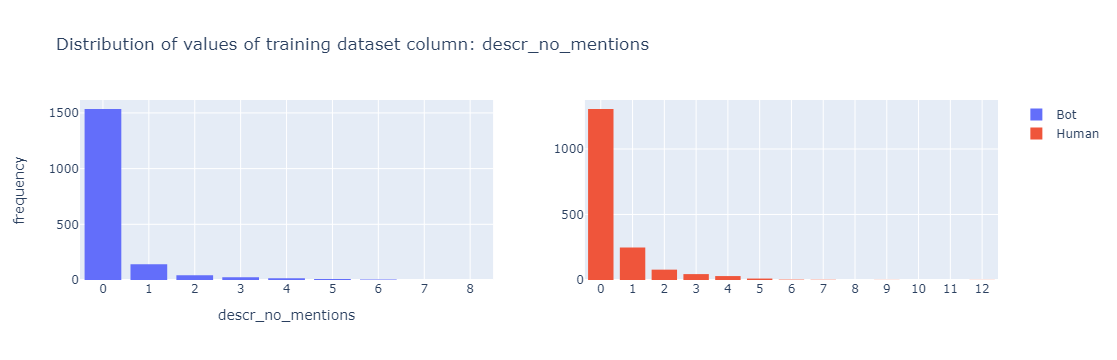

In [467]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_urls - outliers

In [468]:
df_reduced_outliers_descr_no_urls = df_99_percentile(df=train_data, column_name='descr_no_urls')

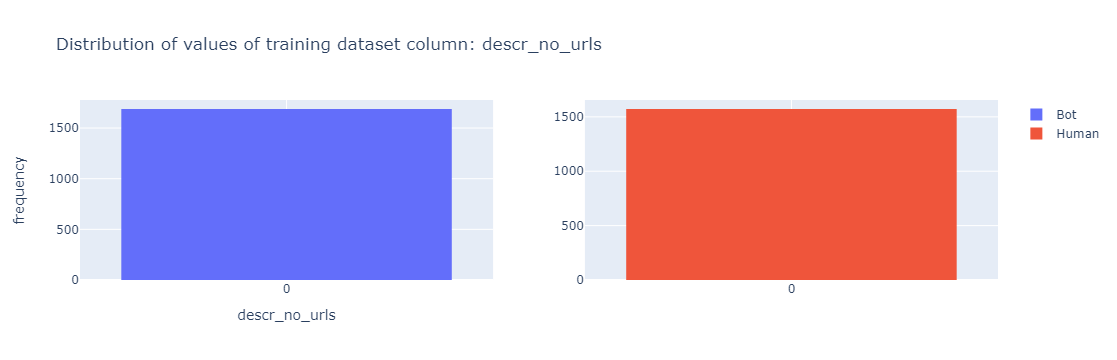

In [469]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_urls.loc[df_reduced_outliers_descr_no_urls['label']==1,'descr_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_urls.loc[df_reduced_outliers_descr_no_urls['label']==0,'descr_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_urls',
    xaxis_title_text='descr_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

Better to drop this column (DONE, droped later)

### url_no_urls

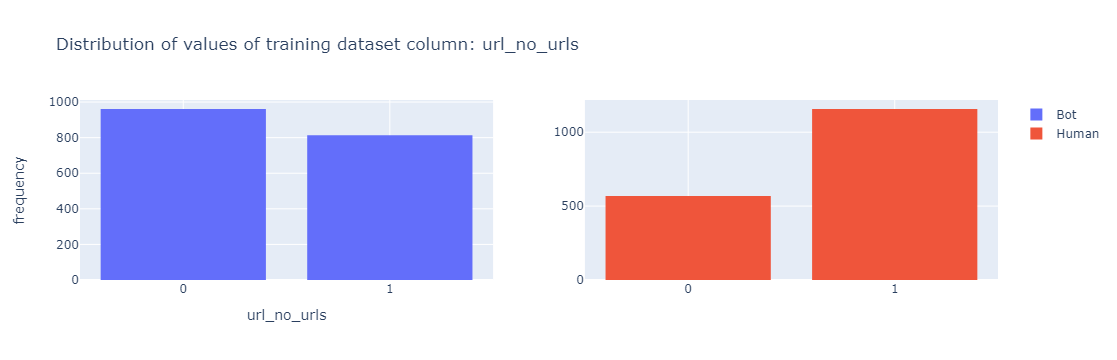

In [470]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: url_no_urls',
    xaxis_title_text='url_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### url_no_urls - outliers

In [471]:
df_reduced_outliers_url_no_urls = df_99_percentile(df=train_data, column_name='url_no_urls')

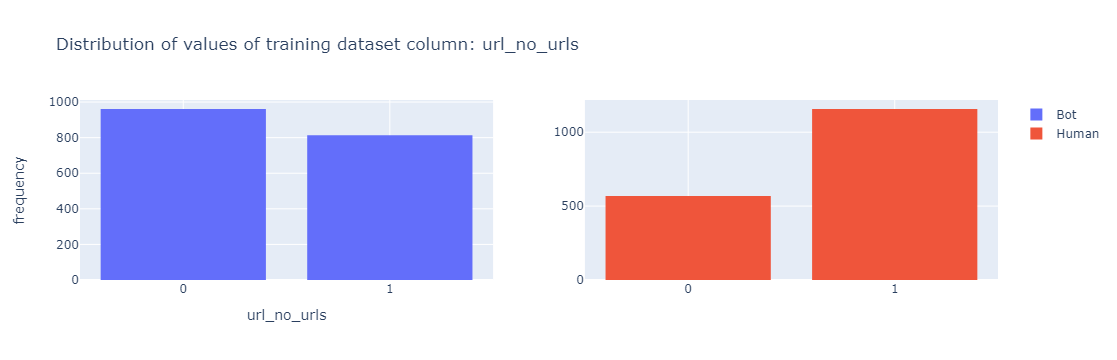

In [472]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_url_no_urls.loc[df_reduced_outliers_url_no_urls['label']==1,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_url_no_urls.loc[df_reduced_outliers_url_no_urls['label']==0,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: url_no_urls',
    xaxis_title_text='url_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_len

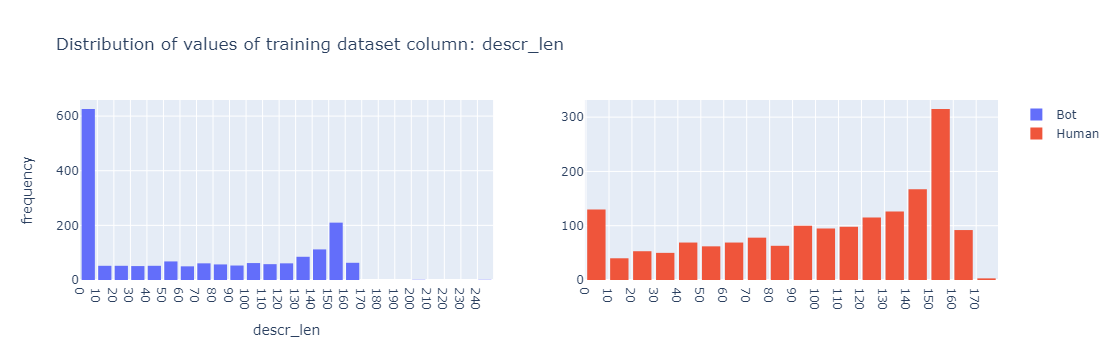

In [473]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_len - outliers

In [474]:
q_hi_bots1 = train_data.loc[train_data['label']==1]['descr_len'].quantile(0.99, interpolation='nearest')
q_hi_humans1 = train_data.loc[train_data['label']==0]['descr_len'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_descr_len =  train_data[((train_data['label']==1) & (train_data['descr_len'] < q_hi_bots1)) | ((train_data['label']==0) & (train_data['descr_len'] < q_hi_humans1))]

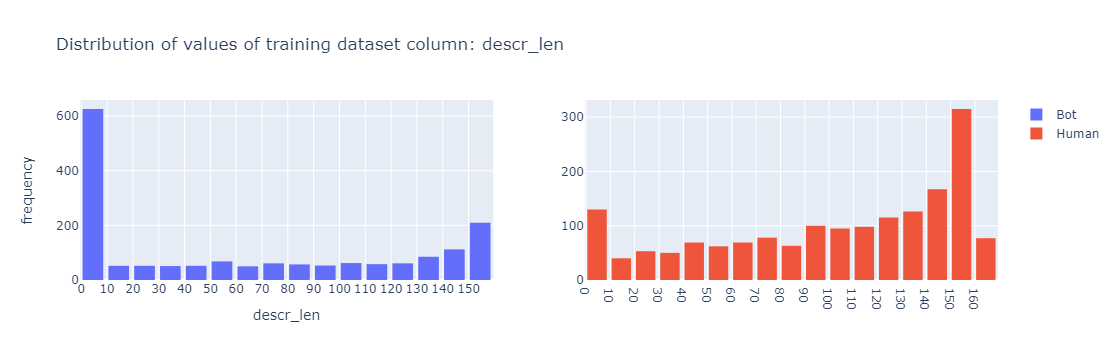

In [475]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_len - outliers (outdated version)

In [476]:
# df_reduced_outliers_descr_len = df_99_percentile(df=train_data, column_name='descr_len')

In [477]:
# fig = go.Figure()
# fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

# fig.add_trace(go.Histogram(
#     x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==1,'descr_len'],
#     # histnorm='density',
#     # nbinsx=30,
#     name='Bot'),
# row=1, col=1
# )
# fig.add_trace(go.Histogram(
#     x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==0,'descr_len'],
#     # histnorm='density',
#     # nbinsx=30,
#     name='Human'),
# row=1, col=2
# )

# fig.update_layout(
#     title_text='Distribution of values of training dataset column: descr_len',
#     xaxis_title_text='descr_len', #'feature',
#     yaxis_title_text='frequency',
#     bargap=0.2,
#     bargroupgap=None, #0.8,
#     width=1100,
#     height=350,
#     legend={"title":""},
#     xaxis=dict(showgrid=True, dtick=10),
#     xaxis2=dict(showgrid=True, dtick=10),
#     yaxis=dict(showgrid=True))

# fig.show()

### account_age

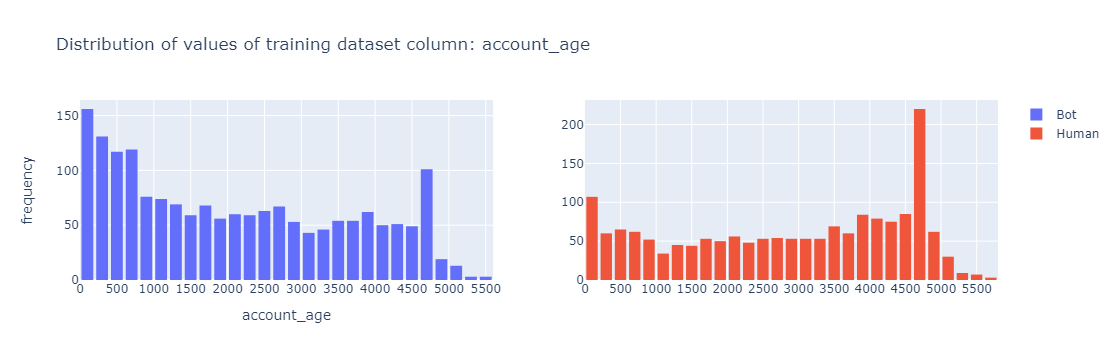

In [478]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500),
    xaxis2=dict(showgrid=True, dtick=500),
    yaxis=dict(showgrid=True))

fig.show()

#### account_age - outliers

In [479]:
q_hi_bots2 = train_data.loc[train_data['label']==1]['account_age'].quantile(0.99, interpolation='nearest')
q_hi_humans2 = train_data.loc[train_data['label']==0]['account_age'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_account_age =  train_data[((train_data['label']==1) & (train_data['account_age'] < q_hi_bots2)) | ((train_data['label']==0) & (train_data['account_age'] < q_hi_humans2))]

### Create merged dataframe from reduced by columns outliers dataframes

In [480]:
train_data_wo_outliers = df_reduced_outliers_followers_count.merge(df_reduced_outliers_following_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

rest_of_df = [df_reduced_outliers_tweet_count, 
              df_reduced_outliers_listed_count, 
              df_reduced_outliers_descr_no_hashtags, 
              df_reduced_outliers_descr_no_cashtags,
              df_reduced_outliers_descr_no_mentions,
              df_reduced_outliers_descr_no_urls,
              df_reduced_outliers_url_no_urls,
              df_reduced_outliers_descr_len,
              df_reduced_outliers_account_age]

for df in rest_of_df:
    if (len(df.loc[df['label']==1]) > 0 and len(df.loc[df['label']==0]) > 0):
        train_data_wo_outliers = train_data_wo_outliers.merge(df, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [481]:
len(train_data)

3500

In [482]:
len(train_data_wo_outliers)

2556

In [483]:
train_data_wo_outliers

id  label  verified  protected  has_location  \
0     1.456436e+18    0.0       0.0        0.0           0.0   
1     3.617436e+07    0.0       0.0        0.0           1.0   
2     3.691750e+08    0.0       0.0        0.0           1.0   
3     1.465260e+08    0.0       0.0        0.0           0.0   
4     6.457821e+07    0.0       0.0        0.0           1.0   
...            ...    ...       ...        ...           ...   
2551  3.053537e+09    0.0       0.0        0.0           1.0   
2552  1.458310e+18    1.0       0.0        0.0           0.0   
2553  4.348814e+09    0.0       0.0        0.0           0.0   
2554  4.953350e+08    0.0       0.0        0.0           1.0   
2555  1.931782e+09    1.0       0.0        0.0           0.0   

      has_profile_image_url  has_pinned_tweet  followers_count  \
0                       1.0               0.0              0.0   
1                       1.0               0.0            444.0   
2                       1.0               1.0           1387.0   
3                       1.0               0.0           1316.0   
4                       1.0               0.0           2957.0   
...                     ...               ...              ...   
2551                    1.0               0.0             12.0   
2552                    1.0               0.0             14.0   
2553                    1.0               0.0             37.0   
2554                    1.0               0.0           1847.0   
2555                    1.0               0.0             12.0   

      following_count  tweet_count  listed_count  has_description  \
0                77.0          4.0           0.0              0.0   
1               345.0        944.0          75.0              1.0   
2              3439.0      48522.0          56.0              1.0   
3              1354.0       1096.0          20.0              0.0   
4               982.0      15872.0         130.0              1.0   
...               ...          ...           ...              ...   
2551             94.0          4.0           0.0              1.0   
2552            853.0         30.0           0.0              1.0   
2553            304.0         30.0           0.0              0.0   
2554           1166.0       8953.0         122.0              1.0   
2555            117.0        670.0           0.0              1.0   

      descr_no_hashtags  descr_no_cashtags  descr_no_mentions  descr_no_urls  \
0                   0.0                0.0                0.0            0.0   
1                   0.0                0.0                0.0            0.0   
2                   0.0                0.0                0.0            0.0   
3                   0.0                0.0                0.0            0.0   
4                   1.0                0.0                0.0            0.0   
...                 ...                ...                ...            ...   
2551                0.0                0.0                0.0            0.0   
2552                0.0                0.0                0.0            0.0   
2553                0.0                0.0                0.0            0.0   
2554                0.0                0.0                0.0            0.0   
2555                0.0                0.0                0.0            0.0   

      url_no_urls  descr_len  account_age  
0             0.0        0.0        131.0  
1             1.0      122.0       4705.0  
2             1.0      124.0       3844.0  
3             1.0        0.0       4317.0  
4             1.0      155.0       4600.0  
...           ...        ...          ...  
2551          0.0       48.0       2572.0  
2552          1.0      122.0        126.0  
2553          1.0        0.0       2296.0  
2554          1.0      159.0       3680.0  
2555          1.0      118.0       3086.0  

[2556 rows x 19 columns]

#### Drop 'id' column

In [484]:
train_data = train_data.drop(['id'], axis=1)
val_data = val_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)

train_data_wo_outliers = train_data_wo_outliers.drop(['id'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['id'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['id'], axis=1)

### Filter to have the same number of records for each class - part II

In [485]:
train_data = filter_df_for_balanced_classes(train_data, bot_label_value=1, human_label_value=0)
val_data = filter_df_for_balanced_classes(val_data, bot_label_value=1, human_label_value=0)
test_data = filter_df_for_balanced_classes(test_data, bot_label_value=1, human_label_value=0)

Number of bots:  1725
Number of human users:  1725
Number of bots:  354
Number of human users:  354
Number of bots:  371
Number of human users:  371


In [486]:
train_data_wo_outliers = filter_df_for_balanced_classes(train_data_wo_outliers, bot_label_value=1, human_label_value=0)
val_data_wo_outliers = filter_df_for_balanced_classes(val_data_wo_outliers, bot_label_value=1, human_label_value=0)
test_data_wo_outliers = filter_df_for_balanced_classes(test_data_wo_outliers, bot_label_value=1, human_label_value=0)

Number of bots:  1245
Number of human users:  1245
Number of bots:  354
Number of human users:  354
Number of bots:  371
Number of human users:  371


## Correlation

In [487]:
sns.set(font_scale=2)

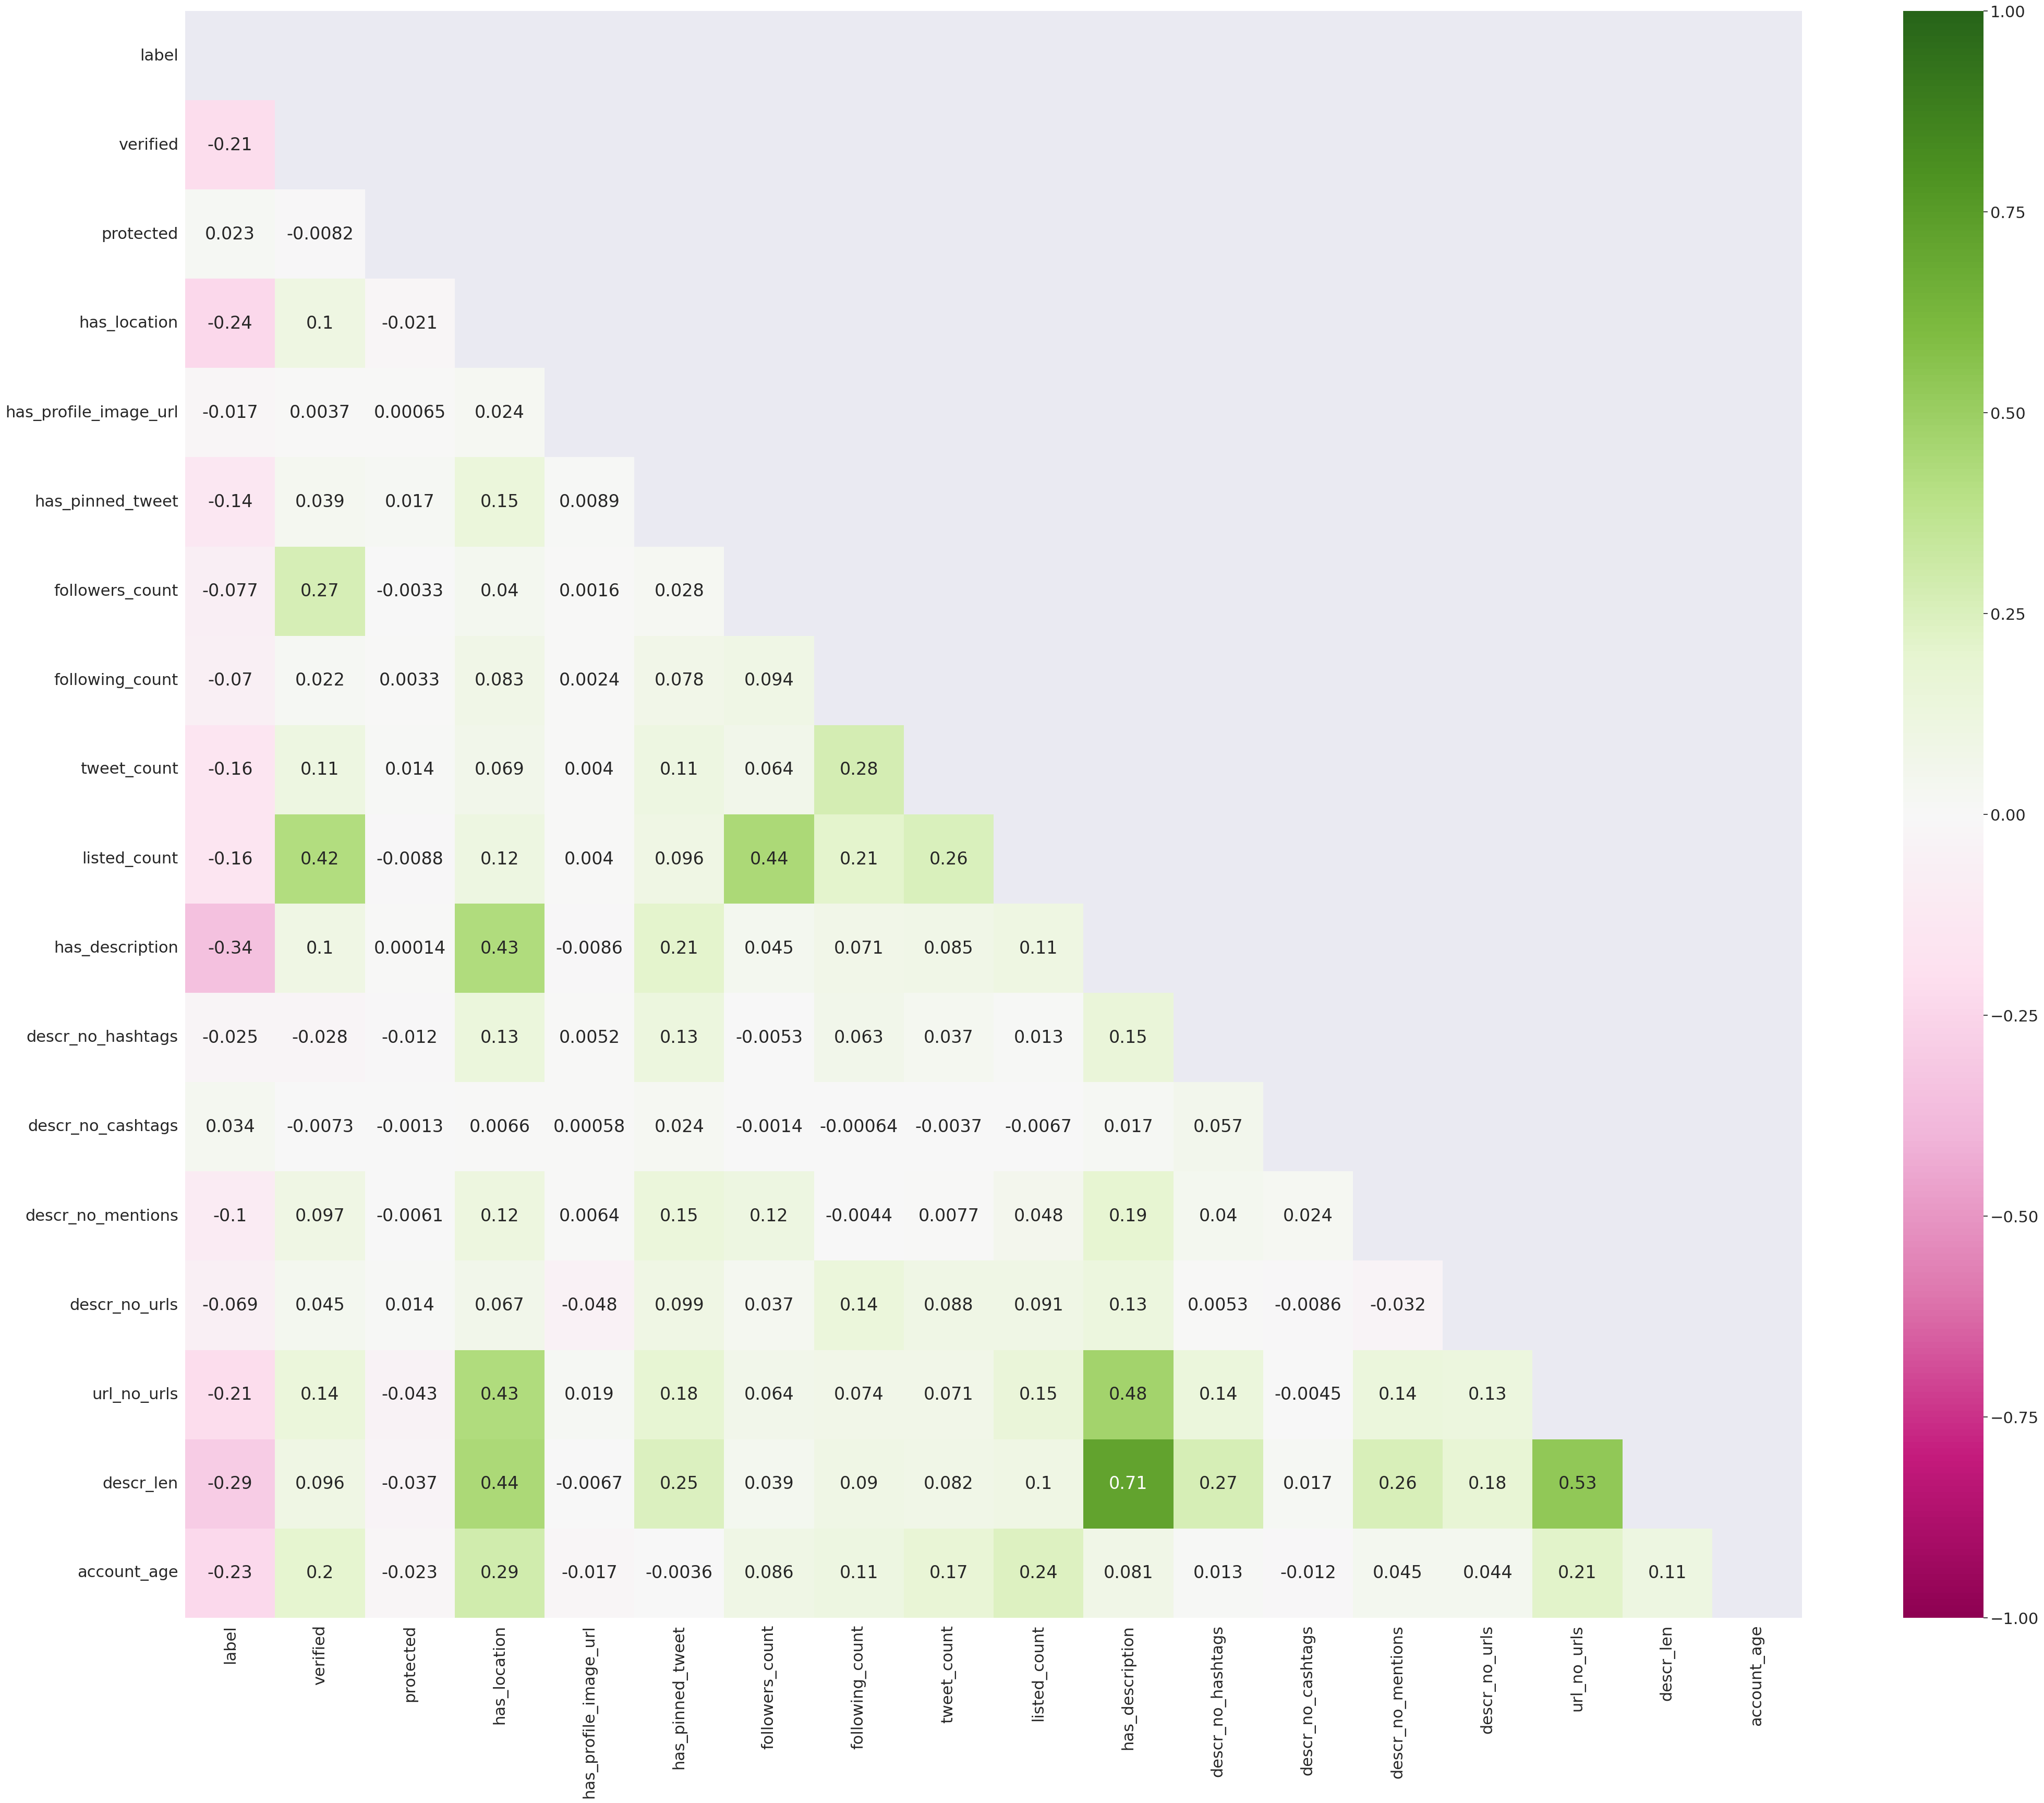

In [488]:
corr_threshold = 0.52
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
         high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [489]:
sns.set(font_scale=1)

In [490]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 2


[('has_description', 'descr_len', 0.71193547643856),
 ('url_no_urls', 'descr_len', 0.5333214106536103)]

In [491]:
train_data

label  verified  protected  has_location  has_profile_image_url  \
1023    0.0       0.0        0.0           0.0                    1.0   
2435    0.0       0.0        0.0           1.0                    1.0   
3723    0.0       0.0        0.0           1.0                    1.0   
1173    0.0       0.0        0.0           0.0                    1.0   
2263    0.0       0.0        0.0           1.0                    1.0   
...     ...       ...        ...           ...                    ...   
1881    0.0       0.0        0.0           1.0                    1.0   
4861    0.0       0.0        0.0           1.0                    1.0   
1175    0.0       0.0        0.0           0.0                    1.0   
255     0.0       0.0        0.0           1.0                    1.0   
2191    0.0       0.0        0.0           1.0                    1.0   

      has_pinned_tweet  followers_count  following_count  tweet_count  \
1023               0.0              0.0             77.0          4.0   
2435               0.0            444.0            345.0        944.0   
3723               1.0           1387.0           3439.0      48522.0   
1173               0.0           1316.0           1354.0       1096.0   
2263               0.0           2957.0            982.0      15872.0   
...                ...              ...              ...          ...   
1881               1.0           1085.0           3953.0       5059.0   
4861               0.0             12.0             94.0          4.0   
1175               0.0             37.0            304.0         30.0   
255                0.0           1847.0           1166.0       8953.0   
2191               0.0          33146.0           8265.0       1305.0   

      listed_count  has_description  descr_no_hashtags  descr_no_cashtags  \
1023           0.0              0.0                0.0                0.0   
2435          75.0              1.0                0.0                0.0   
3723          56.0              1.0                0.0                0.0   
1173          20.0              0.0                0.0                0.0   
2263         130.0              1.0                1.0                0.0   
...            ...              ...                ...                ...   
1881          19.0              1.0                1.0                0.0   
4861           0.0              1.0                0.0                0.0   
1175           0.0              0.0                0.0                0.0   
255          122.0              1.0                0.0                0.0   
2191         830.0              1.0                0.0                0.0   

      descr_no_mentions  descr_no_urls  url_no_urls  descr_len  account_age  
1023                0.0            0.0          0.0        0.0        131.0  
2435                0.0            0.0          1.0      122.0       4705.0  
3723                0.0            0.0          1.0      124.0       3844.0  
1173                0.0            0.0          1.0        0.0       4317.0  
2263                0.0            0.0          1.0      155.0       4600.0  
...                 ...            ...          ...        ...          ...  
1881                2.0            0.0          1.0      148.0       4086.0  
4861                0.0            0.0          0.0       48.0       2572.0  
1175                0.0            0.0          1.0        0.0       2296.0  
255                 0.0            0.0          1.0      159.0       3680.0  
2191                0.0            0.0          1.0       75.0       4727.0  

[3450 rows x 18 columns]

In [492]:
train_data = train_data.drop(['url_no_urls'], axis=1)
val_data = val_data.drop(['url_no_urls'], axis=1)
test_data = test_data.drop(['url_no_urls'], axis=1)

train_data = train_data.drop(['has_description'], axis=1)
val_data = val_data.drop(['has_description'], axis=1)
test_data = test_data.drop(['has_description'], axis=1)

### Correlation of data reduced by outliers

#### First drop columns in filter (without outliers) dataframe where now have same value in whole column

In [493]:
same_data_columns = list(train_data_wo_outliers.columns[train_data_wo_outliers.apply(lambda x: x.nunique()) == 1])
same_data_columns

['has_profile_image_url', 'descr_no_urls']

In [494]:
train_data_wo_outliers = train_data_wo_outliers.drop(same_data_columns, axis=1)

val_data_wo_outliers = val_data_wo_outliers.drop(same_data_columns, axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(same_data_columns, axis=1)

#### Correlation

In [495]:
sns.set(font_scale=2)

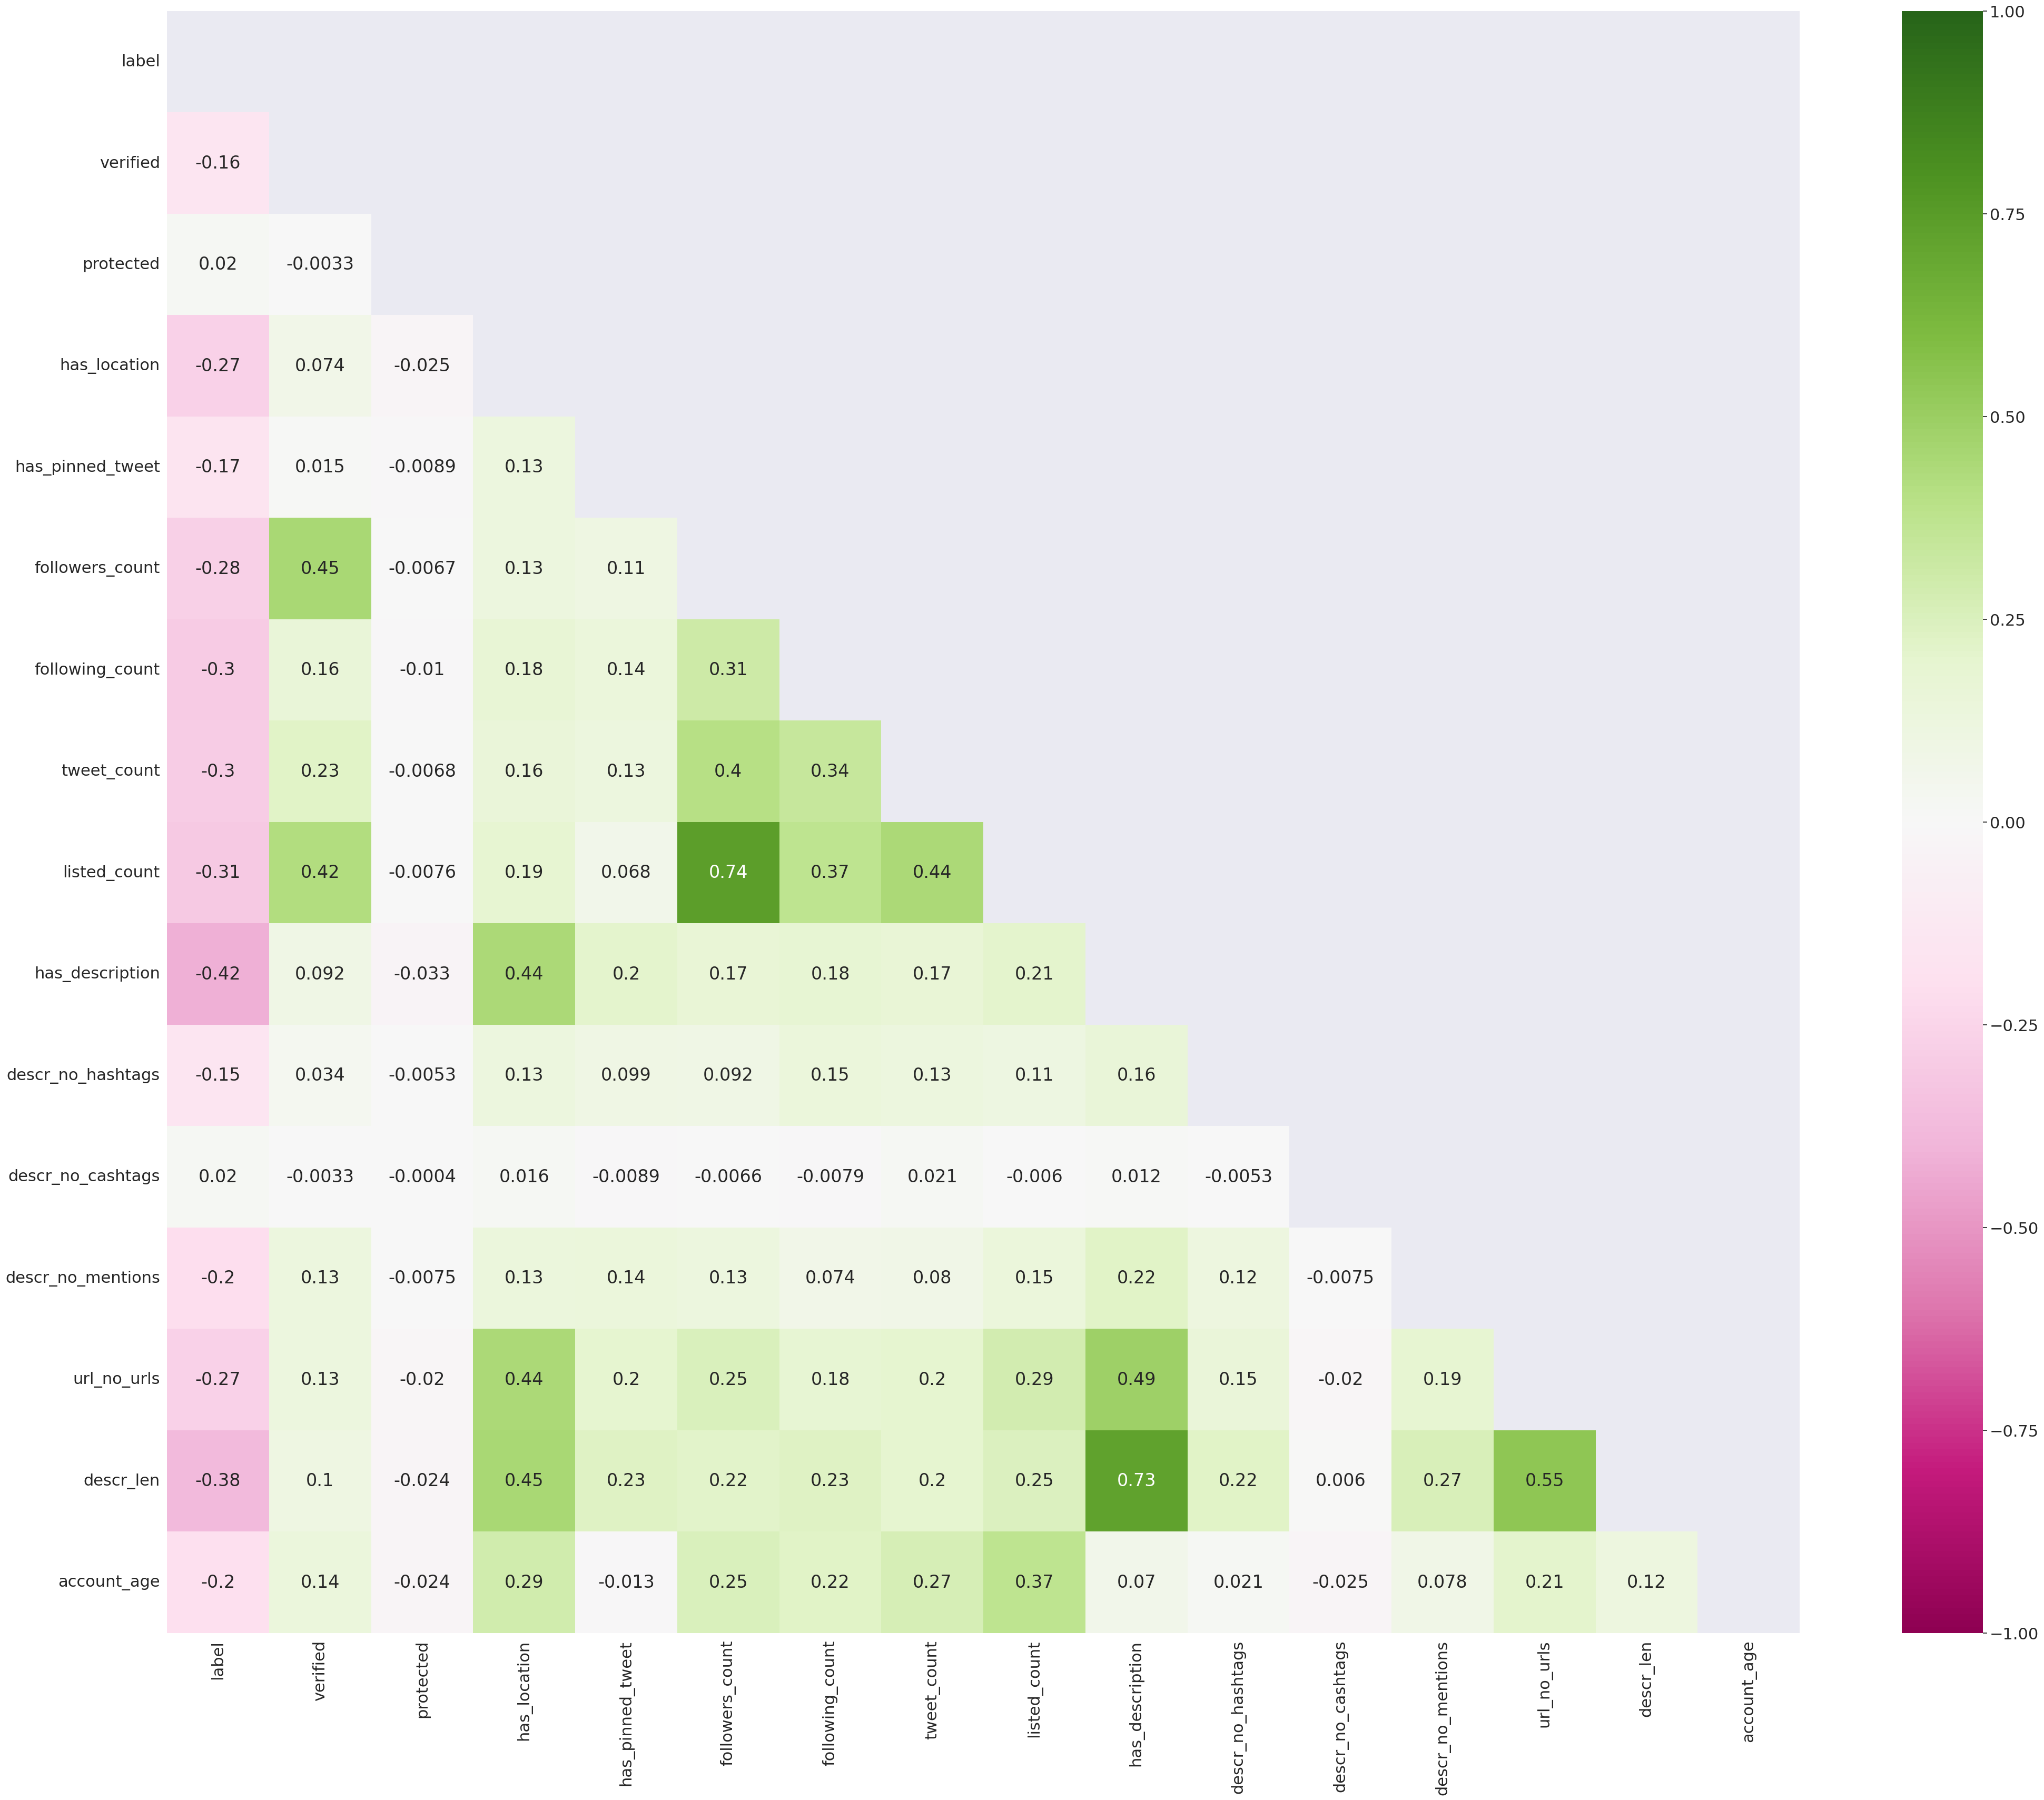

In [496]:
corr_threshold2 = 0.52
corr2 = train_data_wo_outliers.corr()
lower_tri2 = corr2.where(np.tril(np.ones(corr2.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri2, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr2 = []
for column in train_data_wo_outliers:
   for col in train_data_wo_outliers:
     if abs(lower_tri2[column][col]) > corr_threshold2:
         high_corr2.append((column, col, lower_tri2[column][col]))
high_corr2 = sorted(high_corr2, key=lambda x: x[2], reverse=True)

#### Drop column with higher correlation

In [497]:
f = plt.figure(figsize=(50, 40))
sns.set(font_scale=1)

<Figure size 5000x4000 with 0 Axes>

In [498]:
high_corr2

[('followers_count', 'listed_count', 0.7351886089003651),
 ('has_description', 'descr_len', 0.7256708154256074),
 ('url_no_urls', 'descr_len', 0.5458040740171937)]

In [499]:
train_data_wo_outliers = train_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)

#### Split data for input and output

In [500]:
train_X = train_data.drop(['label'], axis=1)
train_Y = pd.concat([train_data['label']], axis=1)
val_X = val_data.drop(['label'], axis=1)
val_Y = pd.concat([val_data['label']], axis=1)
test_X = test_data.drop(['label'], axis=1)
test_Y = pd.concat([test_data['label']], axis=1)


train_data_wo_outliers_X = train_data_wo_outliers.drop(['label'], axis=1)
train_data_wo_outliers_Y = pd.concat([train_data_wo_outliers['label']], axis=1)
val_data_wo_outliers_X = val_data_wo_outliers.drop(['label'], axis=1)
val_data_wo_outliers_Y = pd.concat([val_data_wo_outliers['label']], axis=1)
test_data_wo_outliers_X = test_data_wo_outliers.drop(['label'], axis=1)
test_data_wo_outliers_Y = pd.concat([test_data_wo_outliers['label']], axis=1)

# DNN models

#### Function to load a saved neural network model

In [501]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [502]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [503]:
def create_confusion_matrix(test_Y, out_Y):
    cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure()
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    sns.heatmap(
        cm,
        annot=labels,
        annot_kws={"size": 12},
        fmt='',
        cmap=plt.cm.Blues,
        cbar=False
    )
    ax.set_title("Confusion matrix", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    
    fig.show()

## Neural network models 

In [504]:
# EarlyStopping
def early_stop(metric='val_accuracy', mode = 'max', patience=50):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode=mode)
# PlotLosses
def plot_losses():
    return PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [505]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses(),
                           early_stop(),
                           checkpoint_callback(model_name)])
    return model

## Model 1.

#### Create model

In [506]:
def create_model_1(shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
  model = Sequential()
  model.add(Input(shape=shape)),
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

### batch_size=10, epochs=200

#### Create and train model

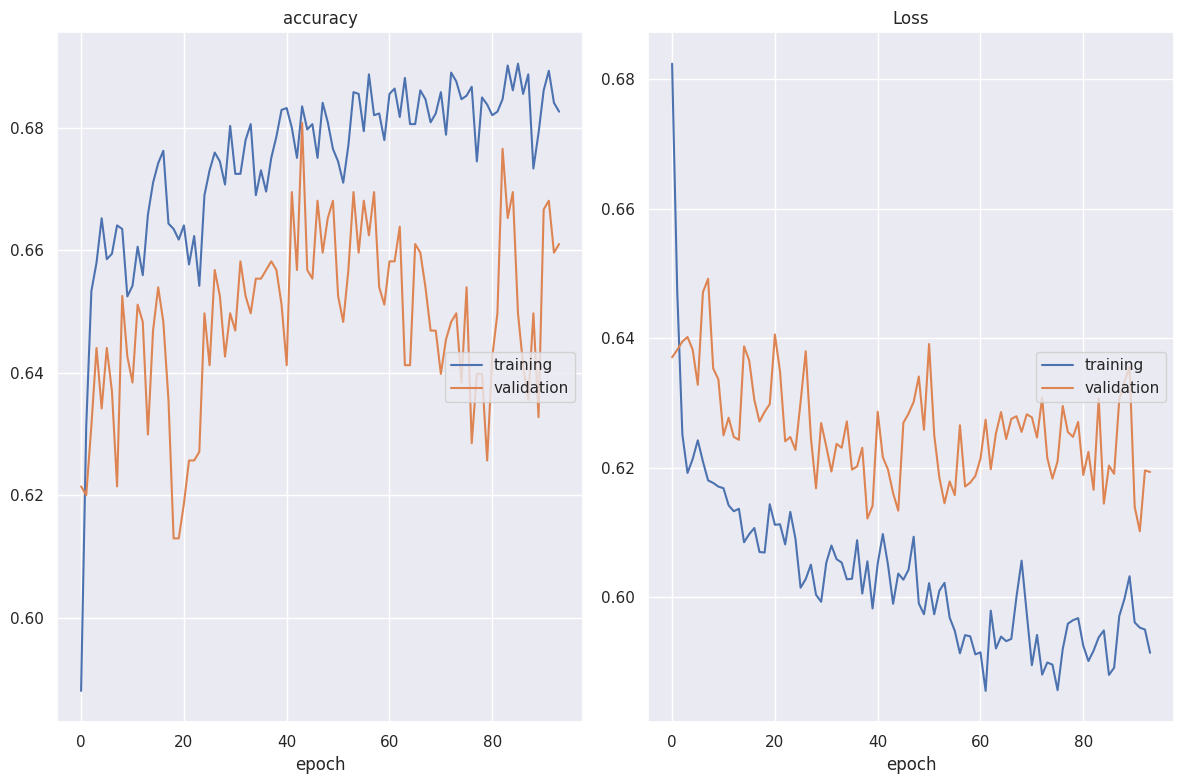

accuracy
	training         	 (min:    0.588, max:    0.690, cur:    0.683)
	validation       	 (min:    0.613, max:    0.681, cur:    0.661)
Loss
	training         	 (min:    0.586, max:    0.682, cur:    0.591)
	validation       	 (min:    0.610, max:    0.649, cur:    0.619)

Epoch 94: val_accuracy did not improve from 0.68079
345/345 [==============================] - 1s 4ms/step - loss: 0.5914 - accuracy: 0.6826 - val_loss: 0.6193 - val_accuracy: 0.6610


In [507]:
model_name = 'model_users_only_5000_1_v1_batch_size_10_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=10, epochs=200)

#### Prediction and results

Accuracy: 0.6455525606469003
Precision: [0.66666667 0.6291866 ]
Recall: 0.7088948787061995
F1 score: 0.666667
ROC AUC: 0.645553


(0.6455525606469003,
 array([0.66666667, 0.6291866 ]),
 0.7088948787061995,
 0.6666666666666667,
 0.6455525606469003)

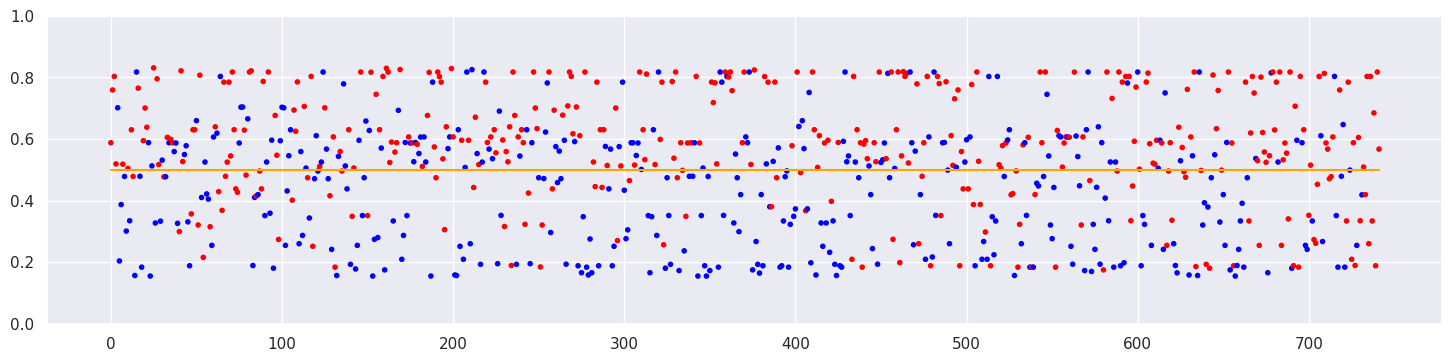

<Figure size 640x480 with 0 Axes>

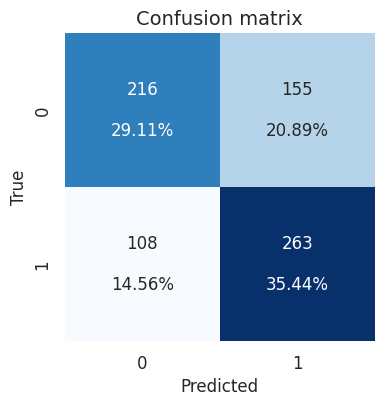

In [508]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=50, epochs=200

In [509]:
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
print(model1_v1.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 32)                512       
                                                                 
 dense_71 (Dense)            (None, 32)                1056      
                                                                 
 dropout_28 (Dropout)        (None, 32)                0         
                                                                 
 dense_72 (Dense)            (None, 64)                2112      
                                                                 
 dense_73 (Dense)            (None, 64)                4160      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_74 (Dense)            (None, 1)               

### Train model

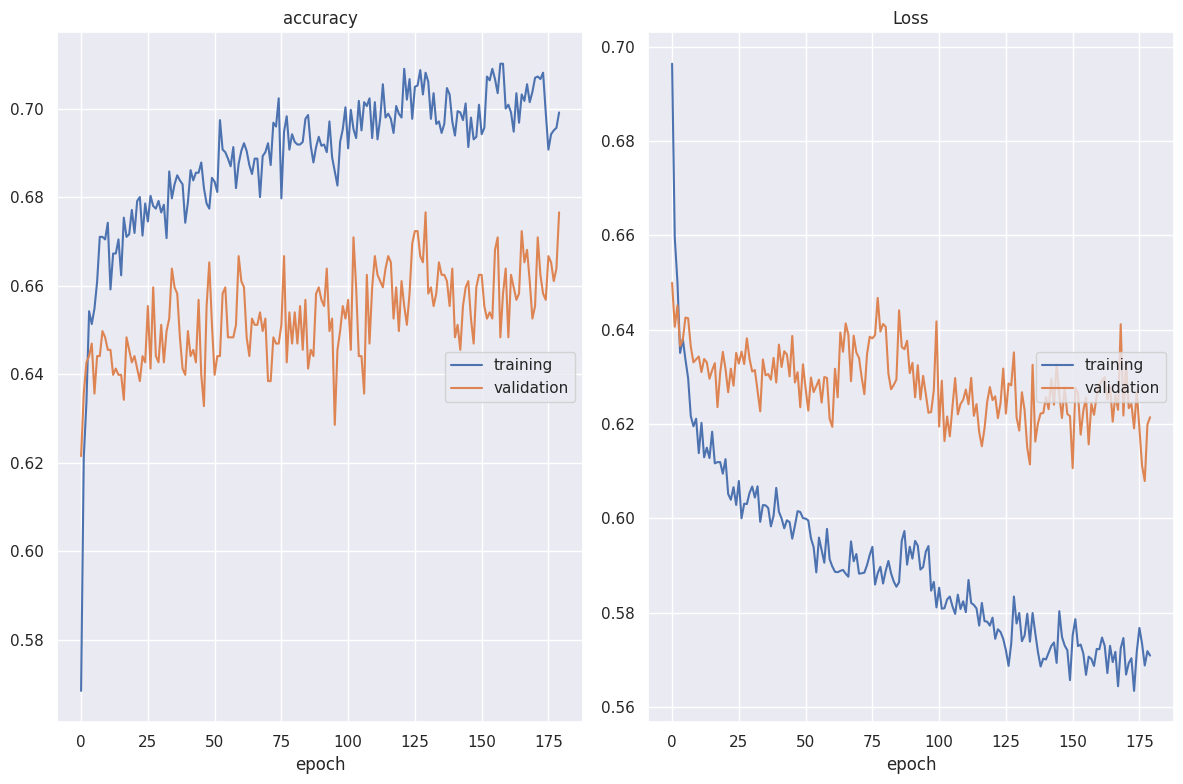

accuracy
	training         	 (min:    0.568, max:    0.710, cur:    0.699)
	validation       	 (min:    0.621, max:    0.677, cur:    0.677)
Loss
	training         	 (min:    0.563, max:    0.696, cur:    0.571)
	validation       	 (min:    0.608, max:    0.650, cur:    0.621)

Epoch 180: val_accuracy did not improve from 0.67655
69/69 [==============================] - 1s 11ms/step - loss: 0.5709 - accuracy: 0.6991 - val_loss: 0.6214 - val_accuracy: 0.6766


In [510]:
model_name = 'model_users_only_5000_1_v1_batch_size_50_epochs_200'
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=50, epochs=200)

In [511]:
# Load model
# model = load_model_from_file(models_path + '/model_name.hdf5')

#### Prediction

In [512]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

#### Results

(0.0, 1.0)

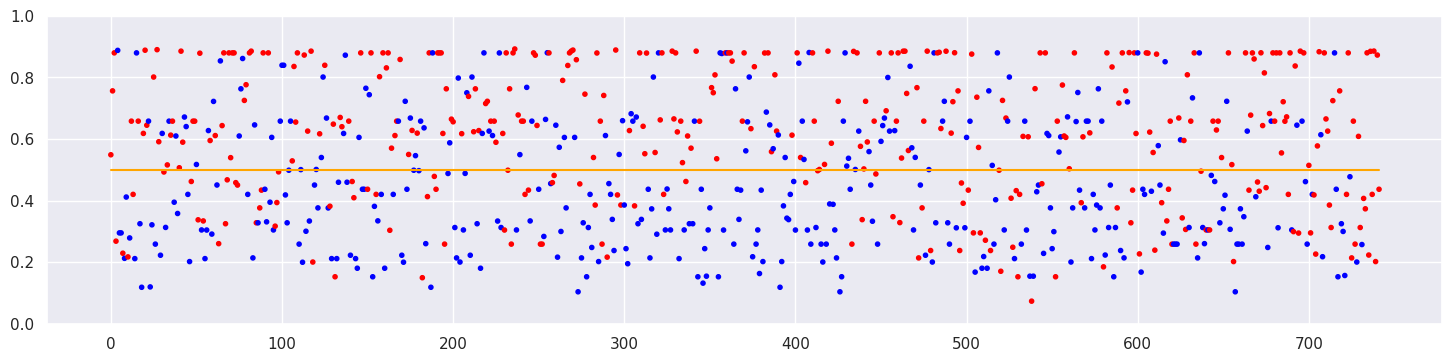

In [513]:
x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

#### Confusion matrix

Accuracy: 0.660377358490566
Precision: [0.66760563 0.65374677]
Recall: 0.6819407008086253
F1 score: 0.667546
ROC AUC: 0.660377


(0.660377358490566,
 array([0.66760563, 0.65374677]),
 0.6819407008086253,
 0.6675461741424802,
 0.660377358490566)

<Figure size 640x480 with 0 Axes>

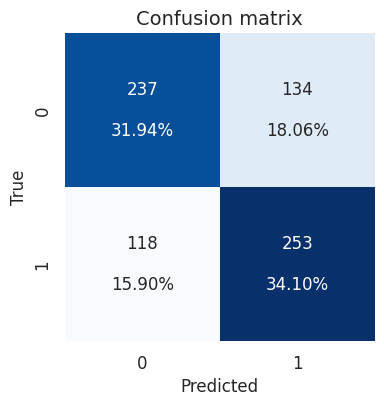

In [514]:
create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=100, epochs=200

#### Create and train model

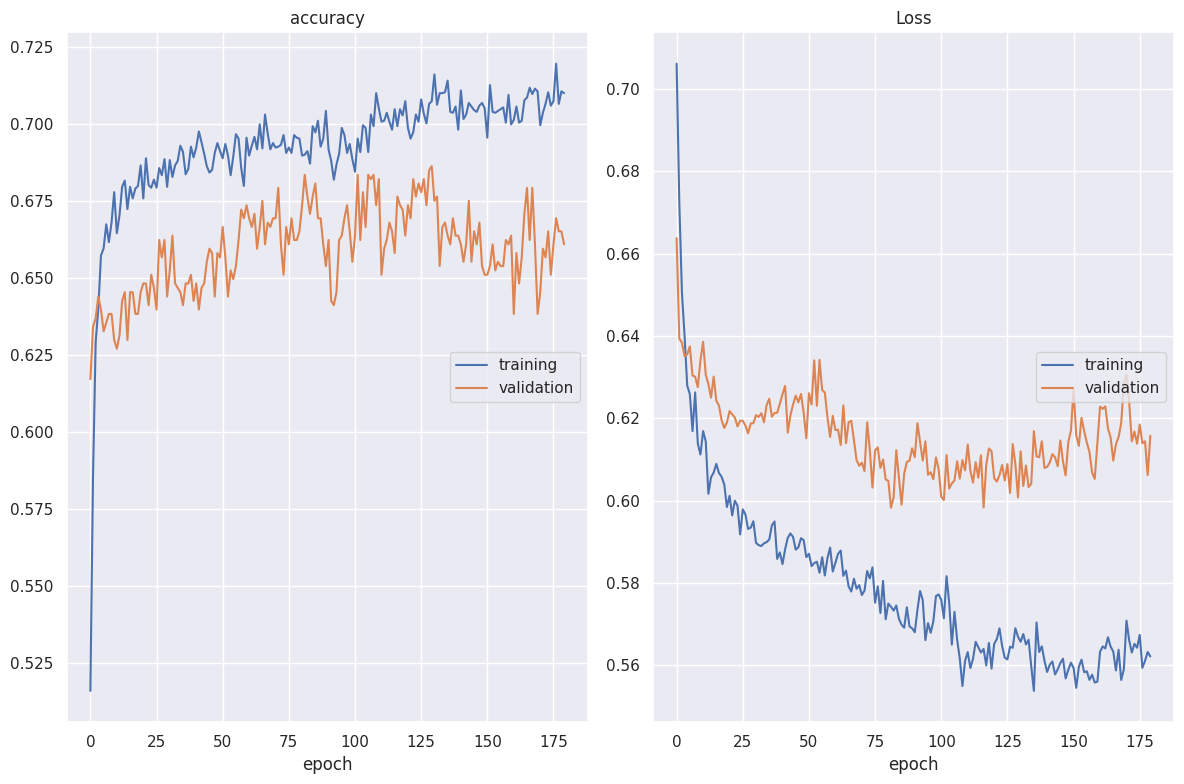

accuracy
	training         	 (min:    0.516, max:    0.720, cur:    0.710)
	validation       	 (min:    0.617, max:    0.686, cur:    0.661)
Loss
	training         	 (min:    0.554, max:    0.706, cur:    0.562)
	validation       	 (min:    0.598, max:    0.664, cur:    0.616)

Epoch 180: val_accuracy did not improve from 0.68644
35/35 [==============================] - 1s 21ms/step - loss: 0.5622 - accuracy: 0.7101 - val_loss: 0.6158 - val_accuracy: 0.6610


In [515]:
model_name = 'model_users_only_5000_1_v1_batch_size_100_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=100, epochs=200)

#### Prediction and results

Accuracy: 0.6549865229110512
Precision: [0.64781491 0.66288952]
Recall: 0.6307277628032345
F1 score: 0.646409
ROC AUC: 0.654987


(0.6549865229110512,
 array([0.64781491, 0.66288952]),
 0.6307277628032345,
 0.6464088397790055,
 0.6549865229110513)

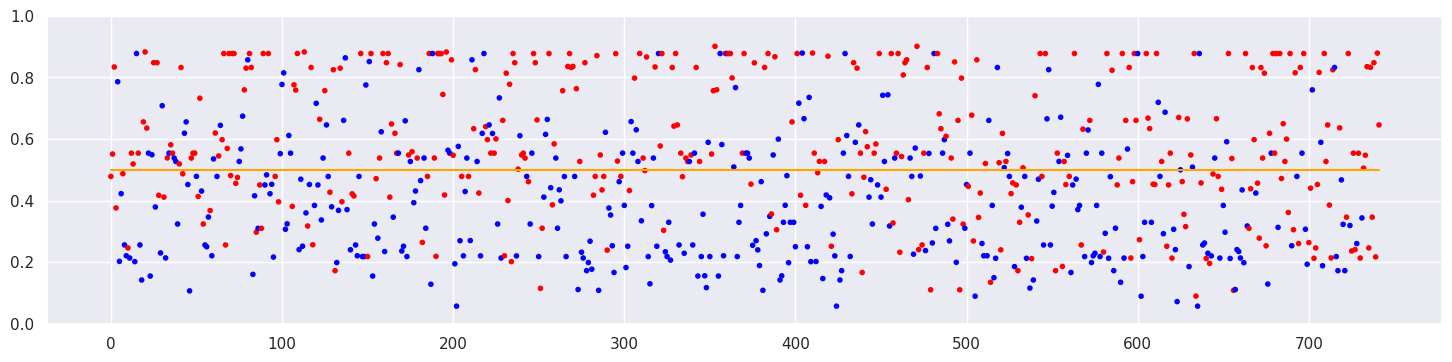

<Figure size 640x480 with 0 Axes>

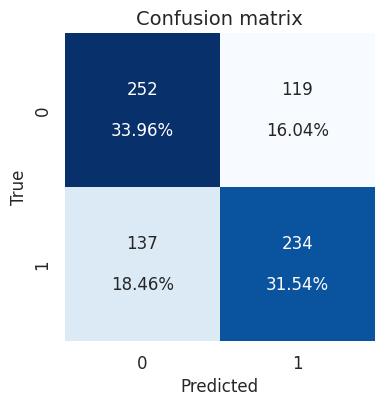

In [516]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=150, epochs=200

#### Create and train model

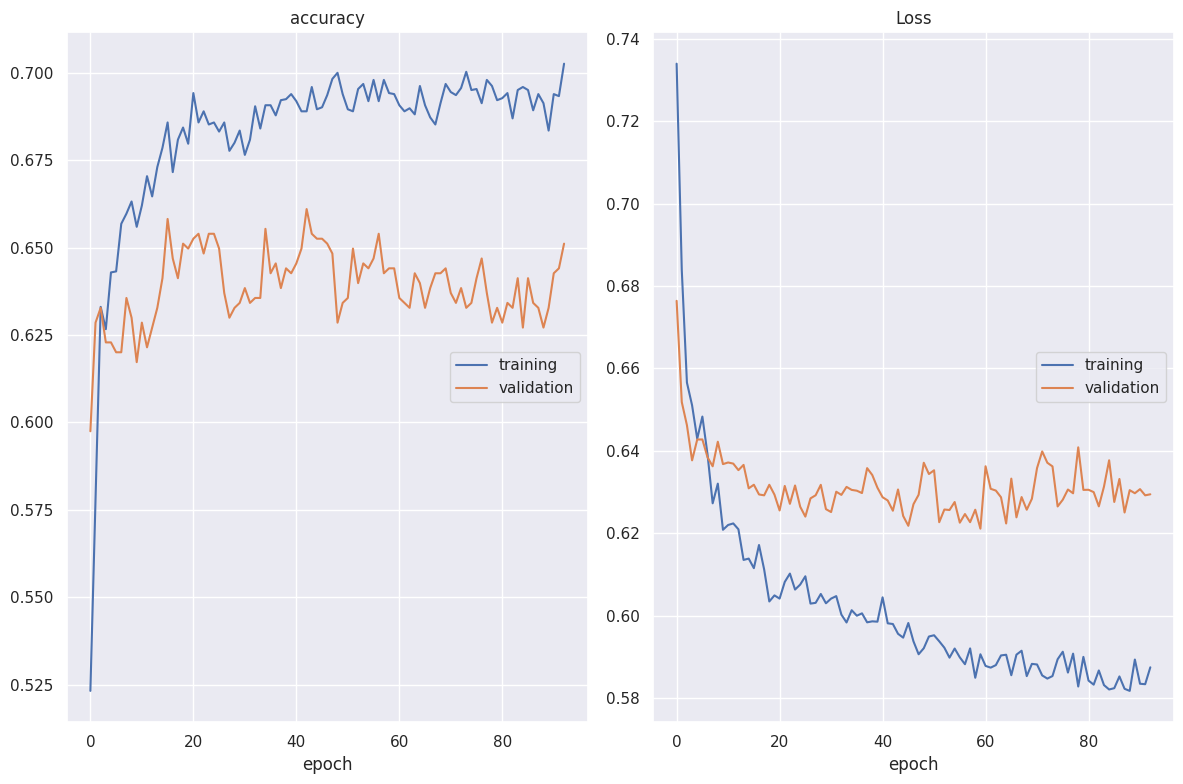

accuracy
	training         	 (min:    0.523, max:    0.703, cur:    0.703)
	validation       	 (min:    0.597, max:    0.661, cur:    0.651)
Loss
	training         	 (min:    0.582, max:    0.734, cur:    0.587)
	validation       	 (min:    0.621, max:    0.676, cur:    0.629)

Epoch 93: val_accuracy did not improve from 0.66102
23/23 [==============================] - 1s 28ms/step - loss: 0.5874 - accuracy: 0.7026 - val_loss: 0.6294 - val_accuracy: 0.6511


In [517]:
model_name = 'model_users_only_5000_1_v1_batch_size_150_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=150, epochs=200)

#### Prediction and results

Accuracy: 0.6401617250673854
Precision: [0.64942529 0.6319797 ]
Recall: 0.6711590296495957
F1 score: 0.650980
ROC AUC: 0.640162


(0.6401617250673854,
 array([0.64942529, 0.6319797 ]),
 0.6711590296495957,
 0.6509803921568628,
 0.6401617250673854)

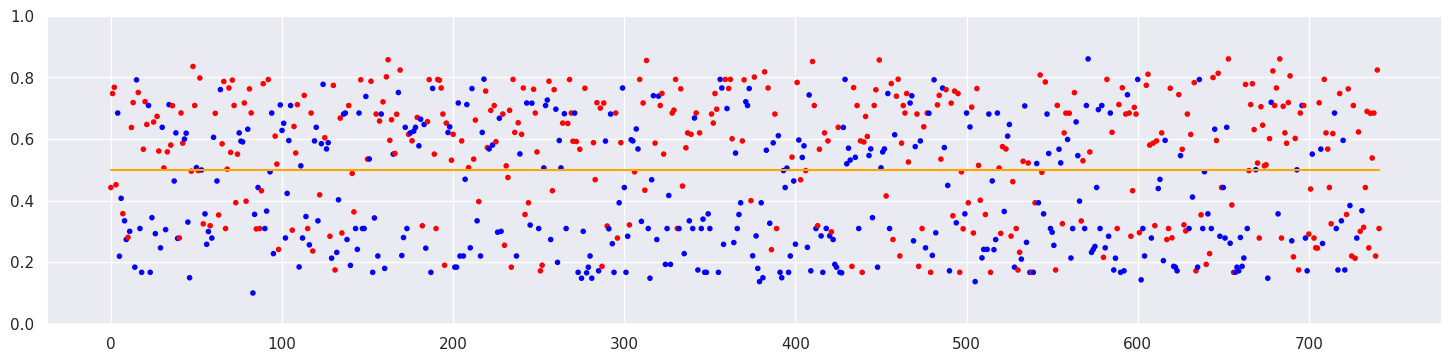

<Figure size 640x480 with 0 Axes>

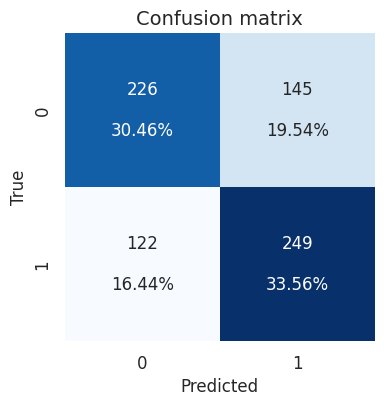

In [518]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=200, epochs=200

#### Create and train model

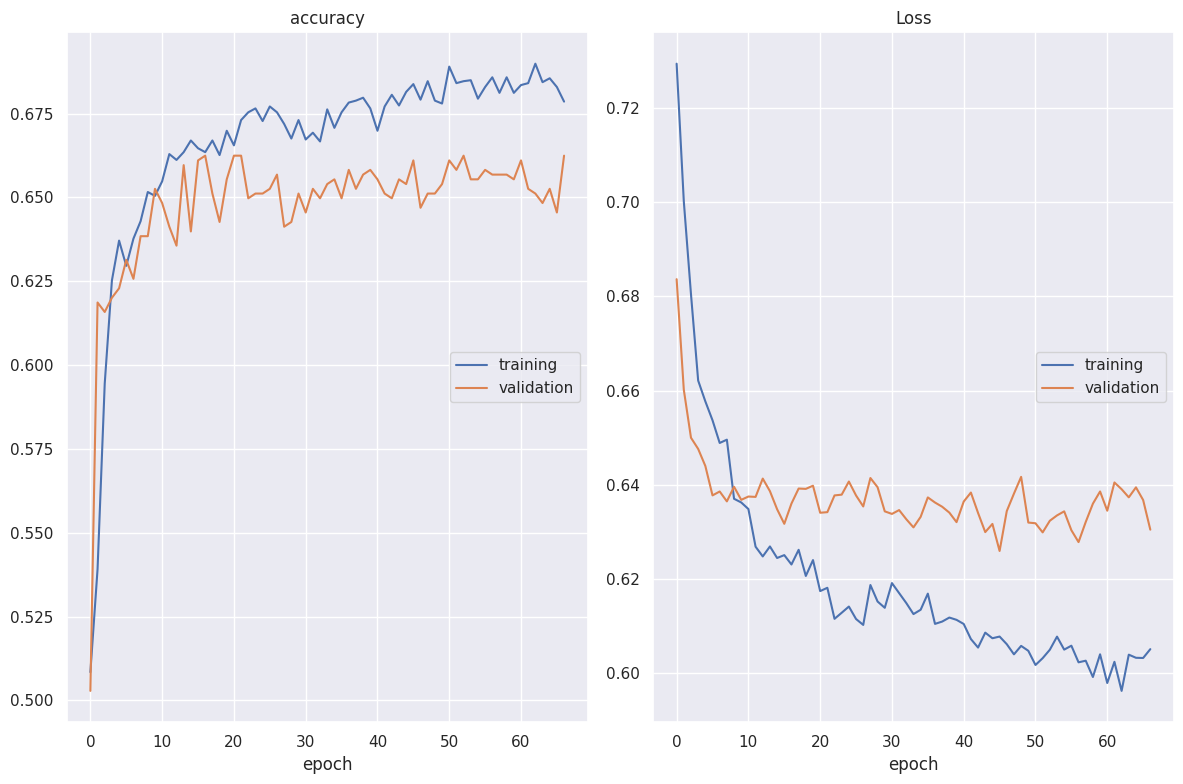

accuracy
	training         	 (min:    0.508, max:    0.690, cur:    0.679)
	validation       	 (min:    0.503, max:    0.662, cur:    0.662)
Loss
	training         	 (min:    0.596, max:    0.729, cur:    0.605)
	validation       	 (min:    0.626, max:    0.684, cur:    0.631)

Epoch 67: val_accuracy did not improve from 0.66243
18/18 [==============================] - 1s 37ms/step - loss: 0.6052 - accuracy: 0.6786 - val_loss: 0.6305 - val_accuracy: 0.6624


In [519]:
model_name = 'model_users_only_5000_1_v1_batch_size_200_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=200, epochs=200)

#### Prediction and results

Accuracy: 0.6657681940700808
Precision: [0.68249258 0.65185185]
Recall: 0.7115902964959568
F1 score: 0.680412
ROC AUC: 0.665768


(0.6657681940700808,
 array([0.68249258, 0.65185185]),
 0.7115902964959568,
 0.6804123711340206,
 0.6657681940700807)

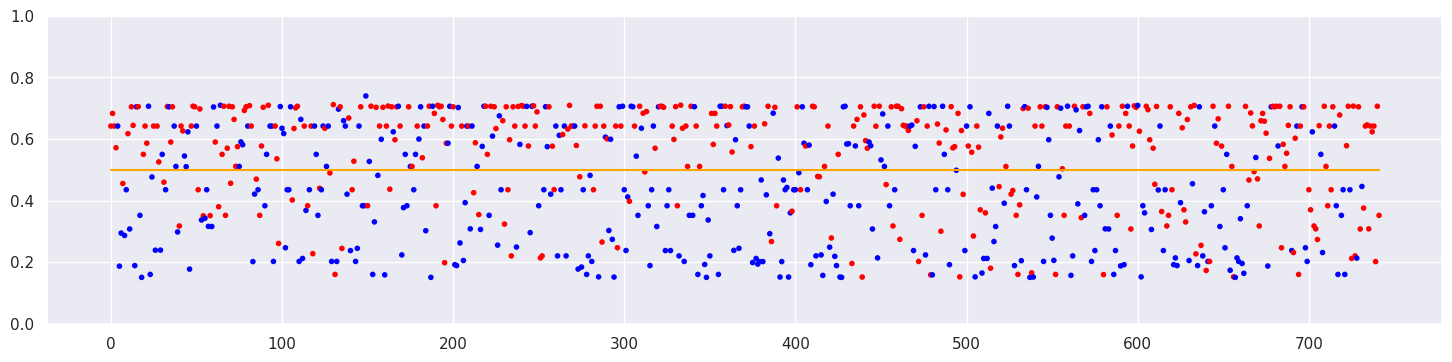

<Figure size 640x480 with 0 Axes>

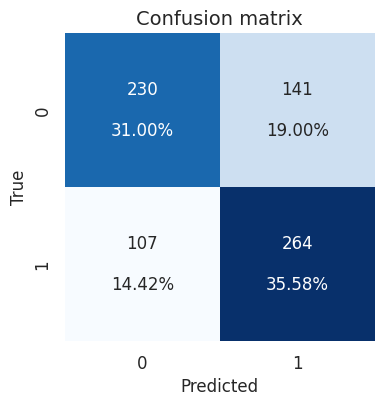

In [520]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=250, epochs=200

#### Create and train model

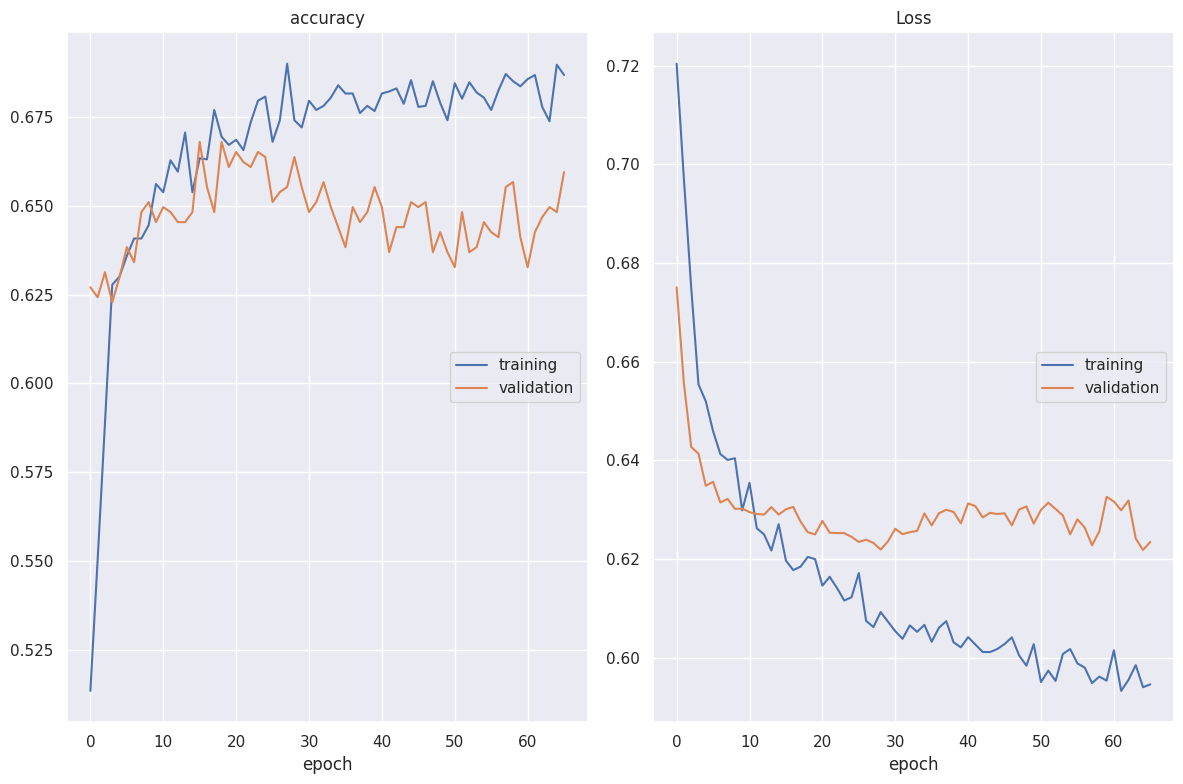

accuracy
	training         	 (min:    0.513, max:    0.690, cur:    0.687)
	validation       	 (min:    0.623, max:    0.668, cur:    0.660)
Loss
	training         	 (min:    0.593, max:    0.720, cur:    0.595)
	validation       	 (min:    0.622, max:    0.675, cur:    0.623)

Epoch 66: val_accuracy did not improve from 0.66808
14/14 [==============================] - 1s 47ms/step - loss: 0.5946 - accuracy: 0.6870 - val_loss: 0.6235 - val_accuracy: 0.6596


In [521]:
model_name = 'model_users_only_5000_1_v1_batch_size_250_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=250, epochs=200)

#### Prediction and results

Accuracy: 0.628032345013477
Precision: [0.65372168 0.60969977]
Recall: 0.7115902964959568
F1 score: 0.656716
ROC AUC: 0.628032


(0.628032345013477,
 array([0.65372168, 0.60969977]),
 0.7115902964959568,
 0.6567164179104478,
 0.628032345013477)

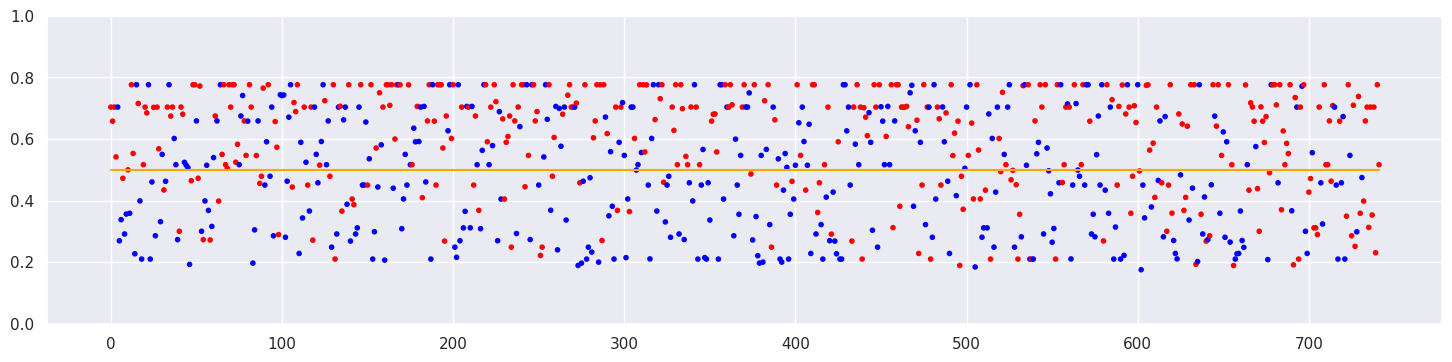

<Figure size 640x480 with 0 Axes>

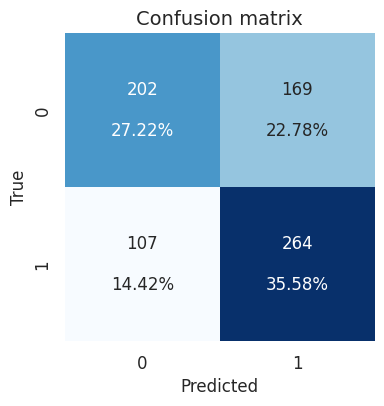

In [522]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### Model 1. - version for data reduced by outliers

### batch_size=10, epochs=200

#### Create and train model

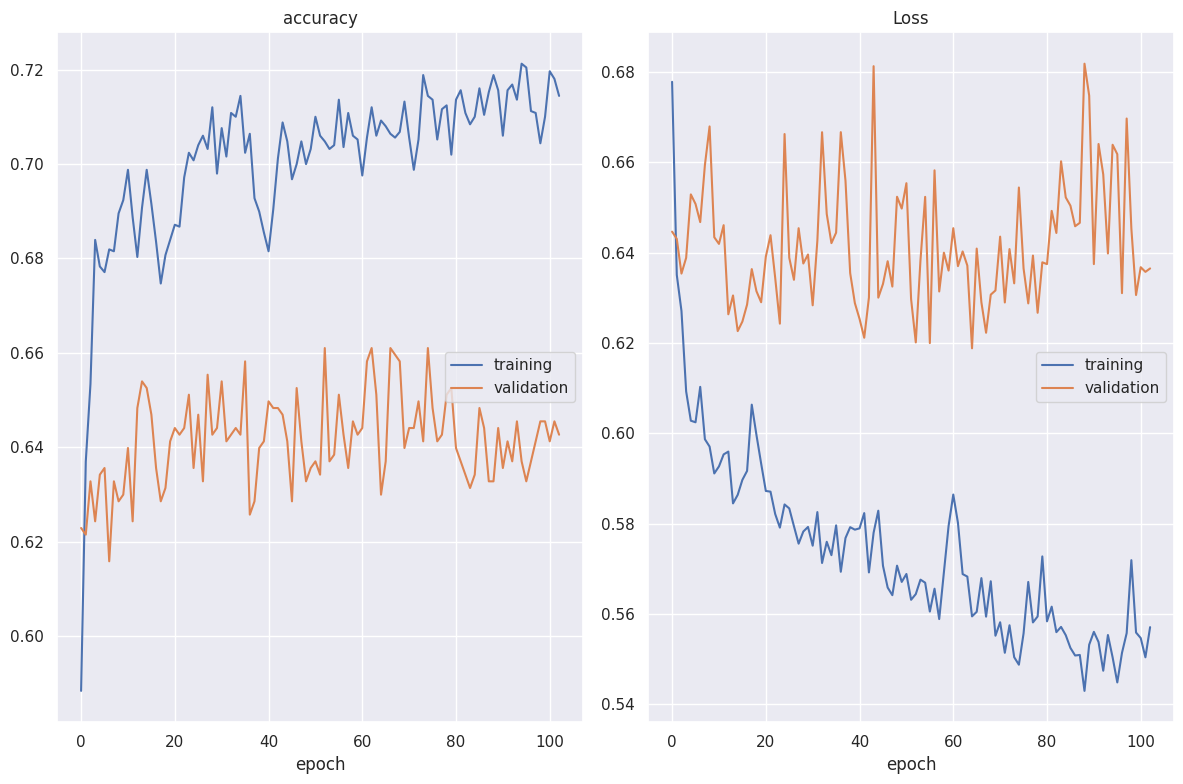

accuracy
	training         	 (min:    0.588, max:    0.721, cur:    0.714)
	validation       	 (min:    0.616, max:    0.661, cur:    0.643)
Loss
	training         	 (min:    0.543, max:    0.678, cur:    0.557)
	validation       	 (min:    0.619, max:    0.682, cur:    0.637)

Epoch 103: val_accuracy did not improve from 0.66102
249/249 [==============================] - 1s 4ms/step - loss: 0.5571 - accuracy: 0.7145 - val_loss: 0.6365 - val_accuracy: 0.6427


In [523]:
model_name = 'model_users_only_5000_1_v2_wo_outliers_batch_size_10_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=10, epochs=200)

#### Prediction and results

Accuracy: 0.623989218328841
Precision: [0.61979167 0.62849162]
Recall: 0.6064690026954178
F1 score: 0.617284
ROC AUC: 0.623989


(0.623989218328841,
 array([0.61979167, 0.62849162]),
 0.6064690026954178,
 0.617283950617284,
 0.6239892183288411)

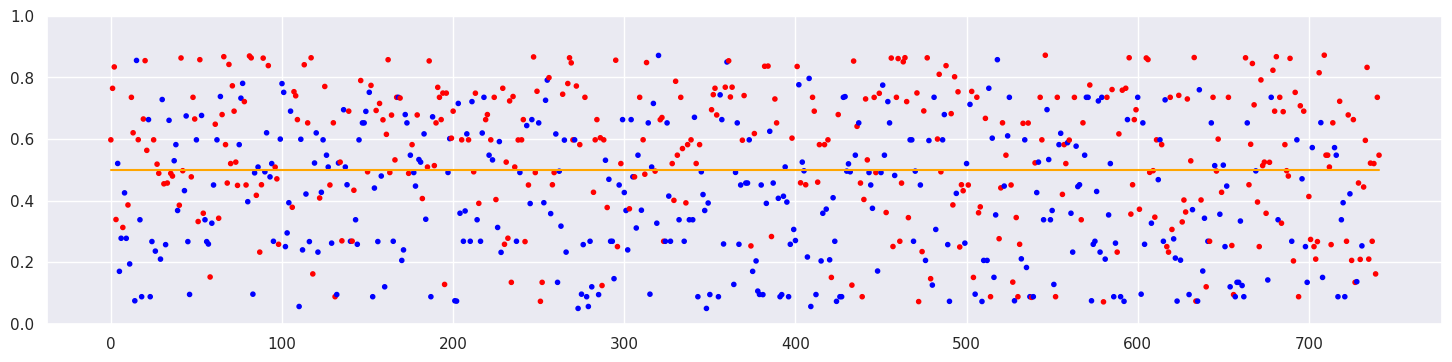

<Figure size 640x480 with 0 Axes>

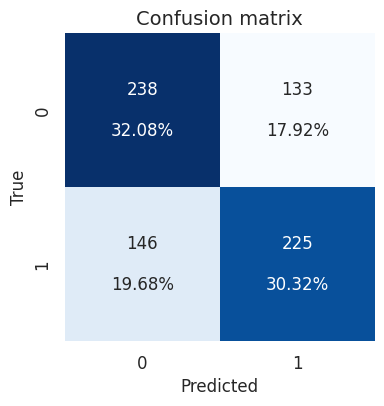

In [524]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=50, epochs=200

#### Create and train model

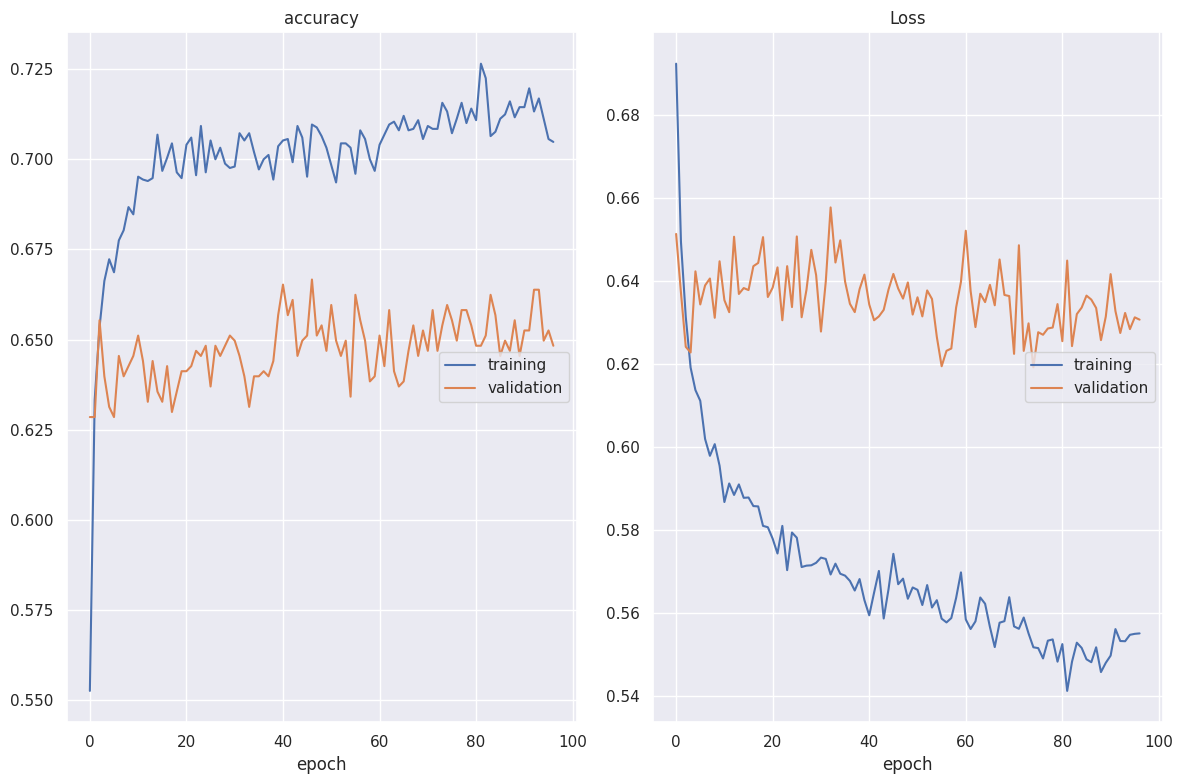

accuracy
	training         	 (min:    0.553, max:    0.727, cur:    0.705)
	validation       	 (min:    0.629, max:    0.667, cur:    0.648)
Loss
	training         	 (min:    0.541, max:    0.692, cur:    0.555)
	validation       	 (min:    0.619, max:    0.658, cur:    0.631)

Epoch 97: val_accuracy did not improve from 0.66667
50/50 [==============================] - 1s 14ms/step - loss: 0.5551 - accuracy: 0.7048 - val_loss: 0.6306 - val_accuracy: 0.6483


In [525]:
model_name = 'model_users_only_5000_1_v2_wo_outliers_batch_size_50_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=50, epochs=200)

#### Prediction and results

Accuracy: 0.6401617250673854
Precision: [0.64857143 0.63265306]
Recall: 0.6684636118598383
F1 score: 0.650066
ROC AUC: 0.640162


(0.6401617250673854,
 array([0.64857143, 0.63265306]),
 0.6684636118598383,
 0.6500655307994757,
 0.6401617250673854)

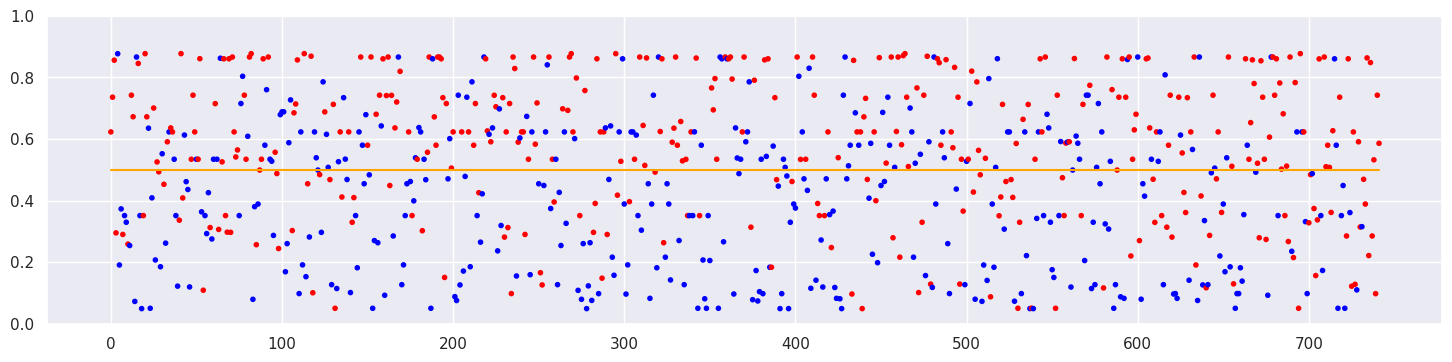

<Figure size 640x480 with 0 Axes>

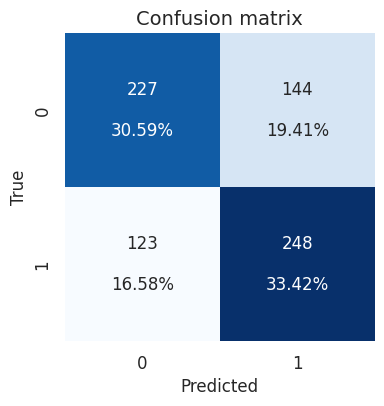

In [526]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=100, epochs=200

#### Create and train model

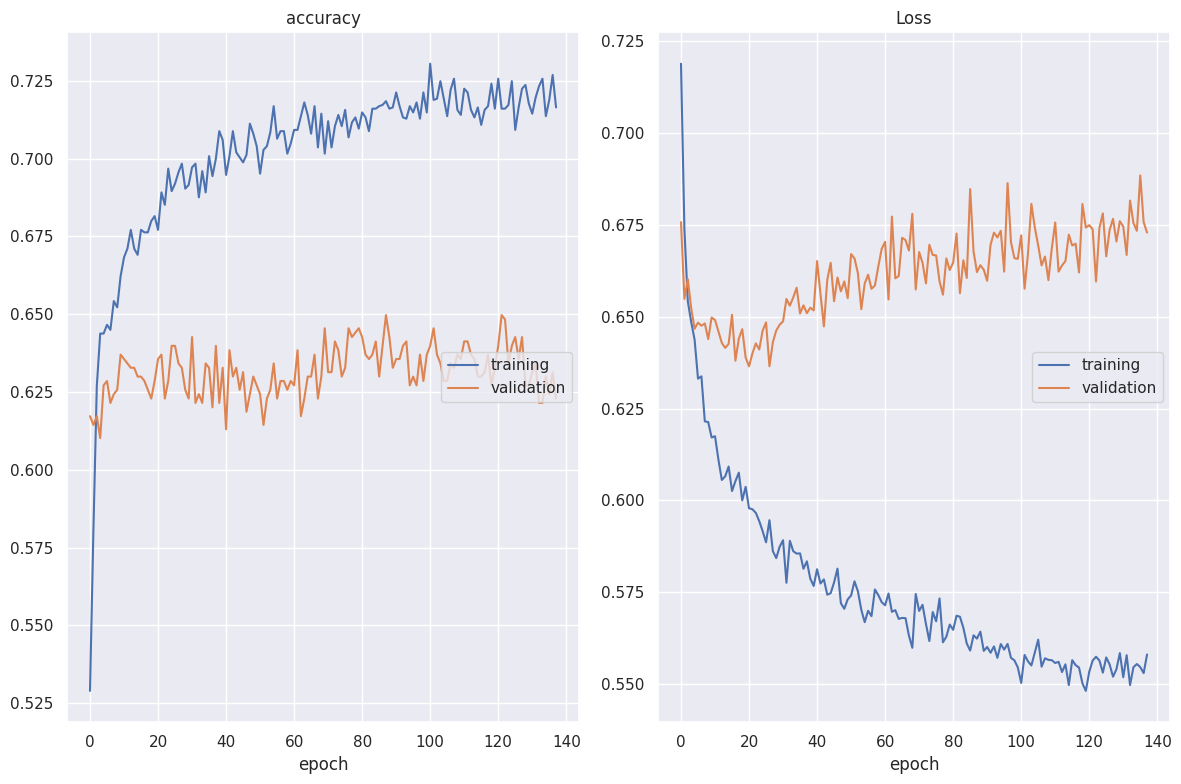

accuracy
	training         	 (min:    0.529, max:    0.731, cur:    0.716)
	validation       	 (min:    0.610, max:    0.650, cur:    0.623)
Loss
	training         	 (min:    0.548, max:    0.719, cur:    0.558)
	validation       	 (min:    0.636, max:    0.688, cur:    0.673)

Epoch 138: val_accuracy did not improve from 0.64972
25/25 [==============================] - 1s 27ms/step - loss: 0.5581 - accuracy: 0.7165 - val_loss: 0.6729 - val_accuracy: 0.6229


In [527]:
model_name = 'model_users_only_5000_1_v2_wo_outliers_batch_size_100_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=100, epochs=200)

#### Prediction and results

Accuracy: 0.6361185983827493
Precision: [0.63835616 0.63395225]
Recall: 0.6442048517520216
F1 score: 0.639037
ROC AUC: 0.636119


(0.6361185983827493,
 array([0.63835616, 0.63395225]),
 0.6442048517520216,
 0.6390374331550802,
 0.6361185983827492)

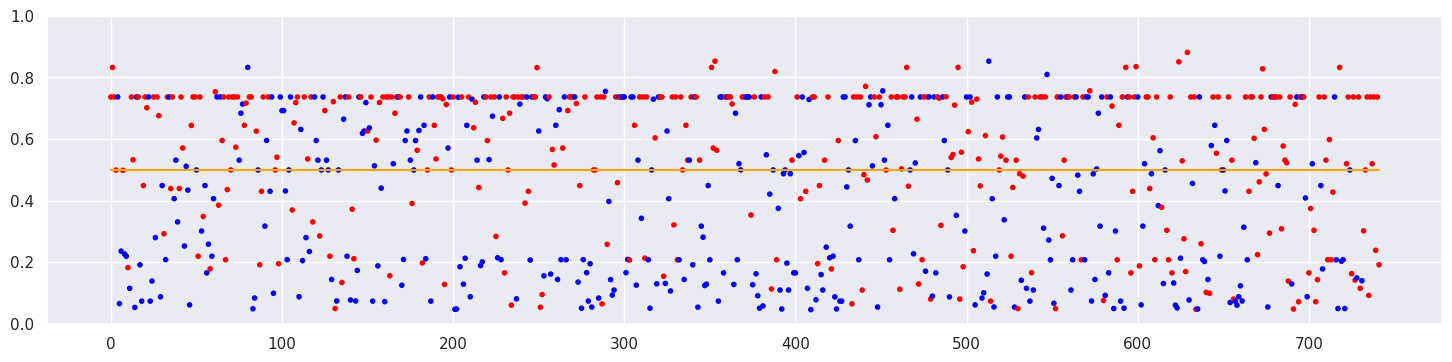

<Figure size 640x480 with 0 Axes>

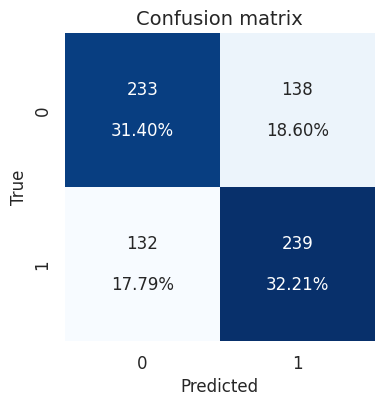

In [528]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=150, epochs=200

#### Create and train model

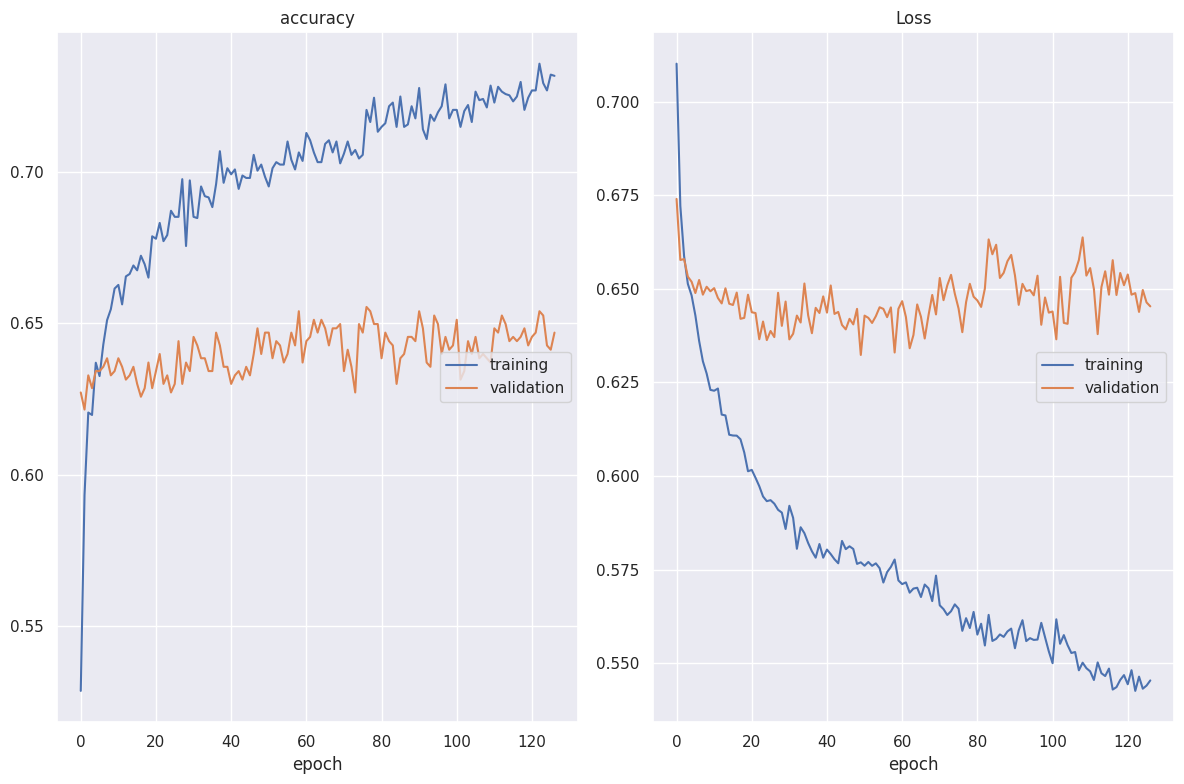

accuracy
	training         	 (min:    0.529, max:    0.736, cur:    0.732)
	validation       	 (min:    0.621, max:    0.655, cur:    0.647)
Loss
	training         	 (min:    0.543, max:    0.710, cur:    0.545)
	validation       	 (min:    0.632, max:    0.674, cur:    0.645)

Epoch 127: val_accuracy did not improve from 0.65537
17/17 [==============================] - 1s 37ms/step - loss: 0.5454 - accuracy: 0.7317 - val_loss: 0.6453 - val_accuracy: 0.6469


In [529]:
model_name = 'model_users_only_5000_1_v2_wo_outliers_batch_size_150_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=150, epochs=200)

#### Prediction and results

Accuracy: 0.6320754716981132
Precision: [0.63101604 0.63315217]
Recall: 0.628032345013477
F1 score: 0.630582
ROC AUC: 0.632075


(0.6320754716981132,
 array([0.63101604, 0.63315217]),
 0.628032345013477,
 0.6305818673883626,
 0.6320754716981132)

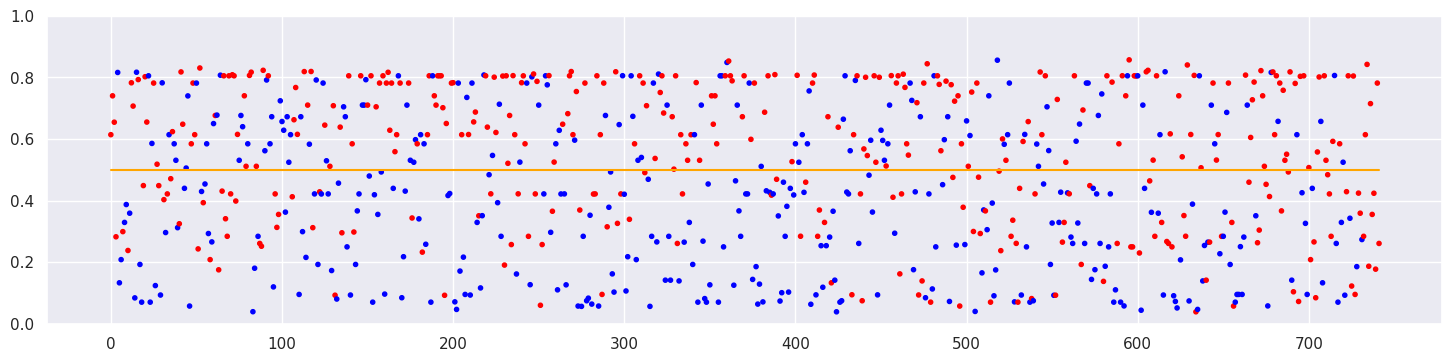

<Figure size 640x480 with 0 Axes>

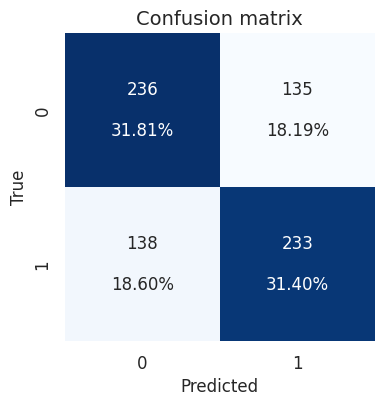

In [530]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=200, epochs=200

#### Create and train model

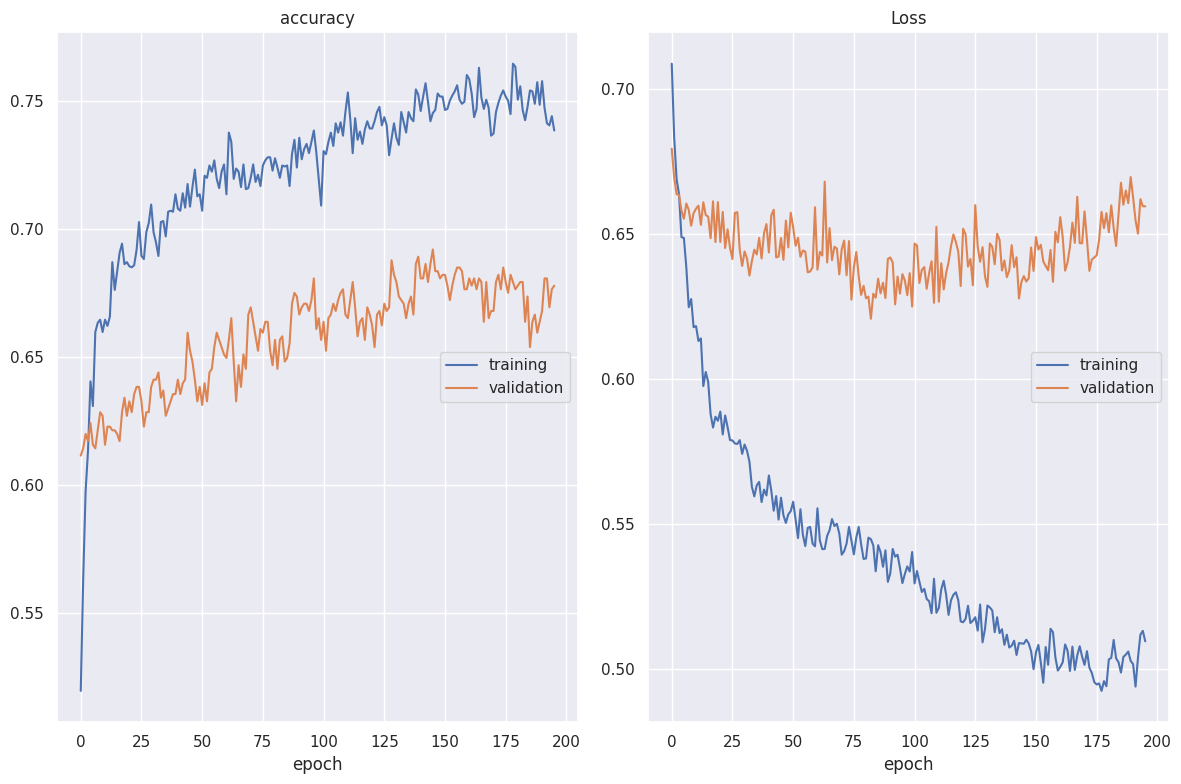

accuracy
	training         	 (min:    0.520, max:    0.765, cur:    0.739)
	validation       	 (min:    0.612, max:    0.692, cur:    0.678)
Loss
	training         	 (min:    0.492, max:    0.709, cur:    0.509)
	validation       	 (min:    0.621, max:    0.679, cur:    0.660)

Epoch 196: val_accuracy did not improve from 0.69209
13/13 [==============================] - 1s 52ms/step - loss: 0.5095 - accuracy: 0.7386 - val_loss: 0.6596 - val_accuracy: 0.6780


In [531]:
model_name = 'model_users_only_5000_1_v2_wo_outliers_batch_size_200_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=200, epochs=200)

#### Prediction and results

Accuracy: 0.6415094339622641
Precision: [0.6342711  0.64957265]
Recall: 0.6145552560646901
F1 score: 0.631579
ROC AUC: 0.641509


(0.6415094339622641,
 array([0.6342711 , 0.64957265]),
 0.6145552560646901,
 0.6315789473684211,
 0.6415094339622642)

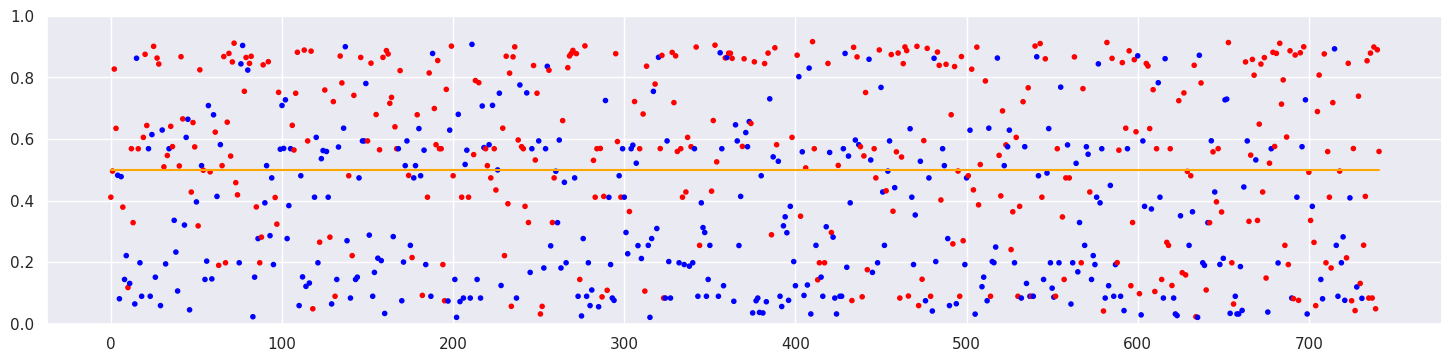

<Figure size 640x480 with 0 Axes>

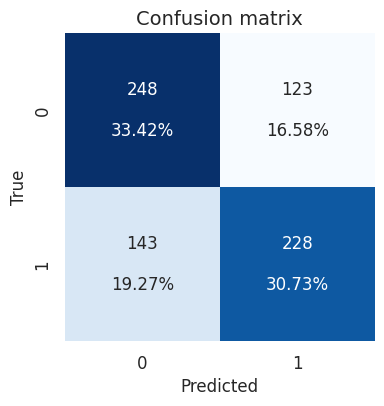

In [532]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=250, epochs=200

#### Create and train model

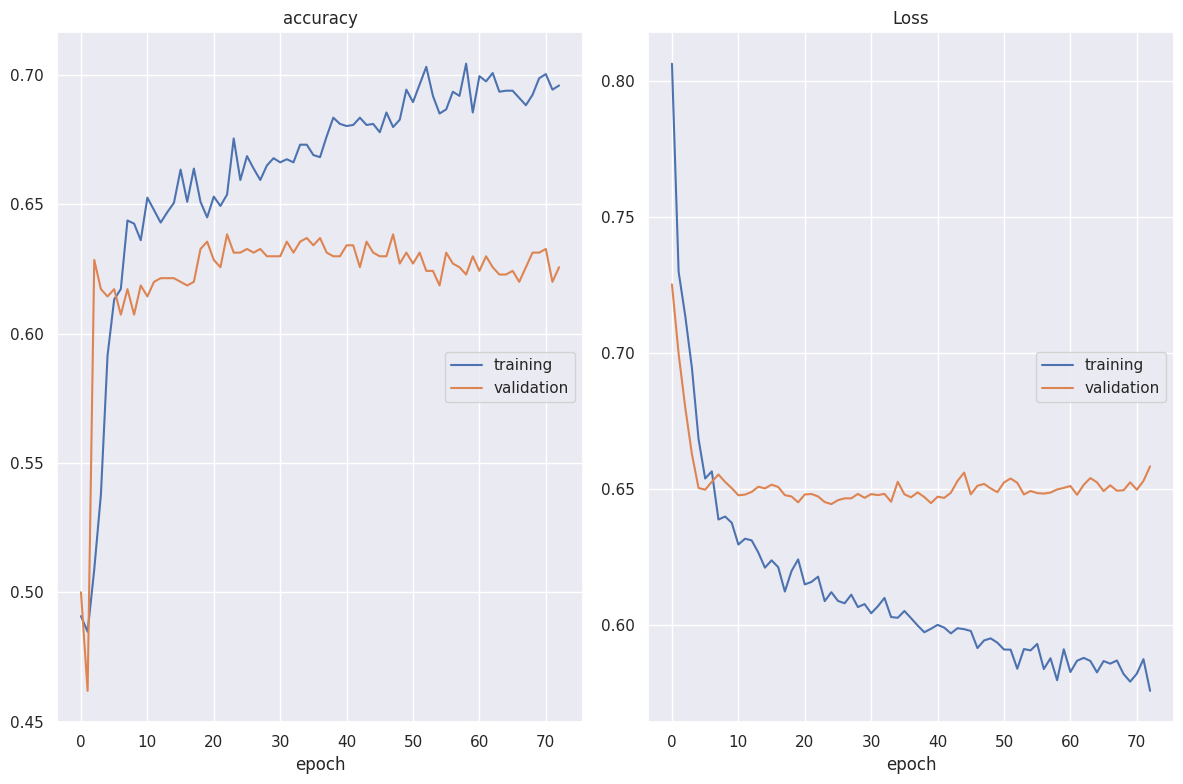

accuracy
	training         	 (min:    0.485, max:    0.704, cur:    0.696)
	validation       	 (min:    0.462, max:    0.638, cur:    0.626)
Loss
	training         	 (min:    0.576, max:    0.806, cur:    0.576)
	validation       	 (min:    0.645, max:    0.725, cur:    0.658)

Epoch 73: val_accuracy did not improve from 0.63842
10/10 [==============================] - 1s 67ms/step - loss: 0.5759 - accuracy: 0.6960 - val_loss: 0.6584 - val_accuracy: 0.6257


In [533]:
model_name = 'model_users_only_5000_1_v2_wo_outliers_batch_size_250_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=250, epochs=200)

#### Prediction and results

Accuracy: 0.6549865229110512
Precision: [0.68852459 0.63157895]
Recall: 0.7439353099730458
F1 score: 0.683168
ROC AUC: 0.654987


(0.6549865229110512,
 array([0.68852459, 0.63157895]),
 0.7439353099730458,
 0.6831683168316832,
 0.6549865229110512)

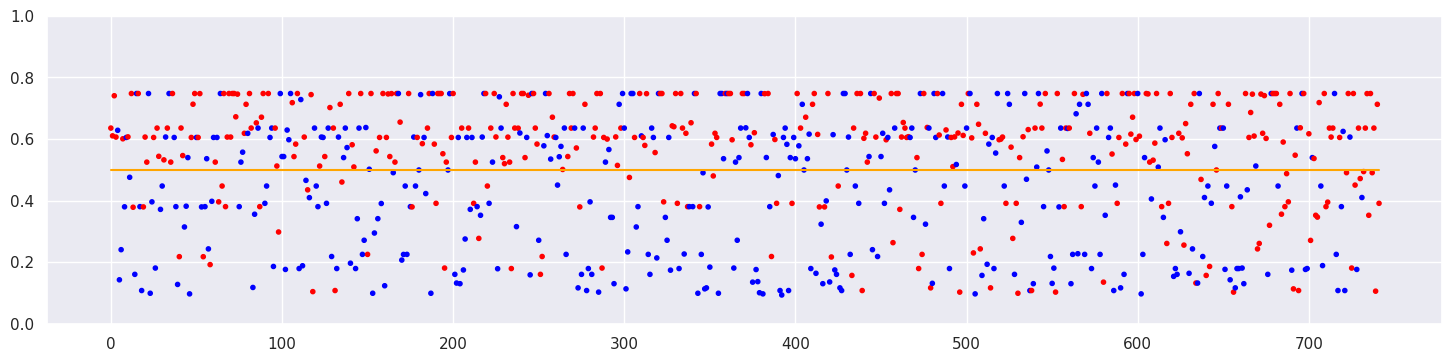

<Figure size 640x480 with 0 Axes>

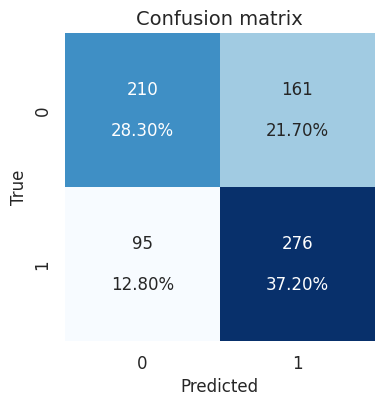

In [534]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

## SHAP (SHapley Additive exPlanations) - done for model 1 v1

In [535]:
shape = (train_X.shape[1],)
model = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())

In [536]:
explainer = shap.DeepExplainer(model, np.asarray(train_X))
shap_values = explainer.shap_values(np.asarray(train_X))

/opt/conda/lib/python3.7/site-packages/shap/explainers/_deep/deep_tf.py:107: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.

/home/jupyter/.local/lib/python3.7/site-packages/keras/backend.py:452: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



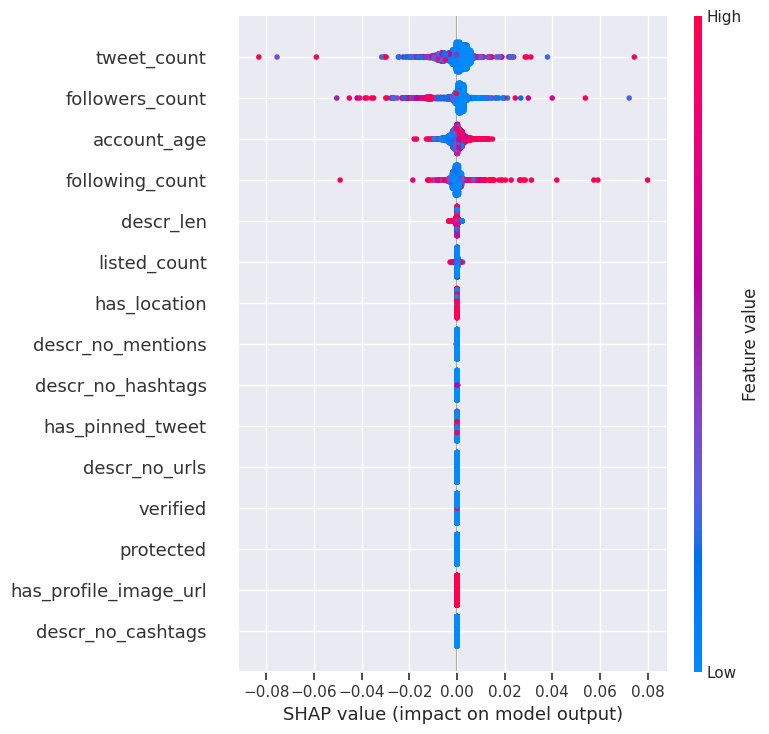

In [537]:
shap.summary_plot(shap_values[0], train_X, plot_type='dot')

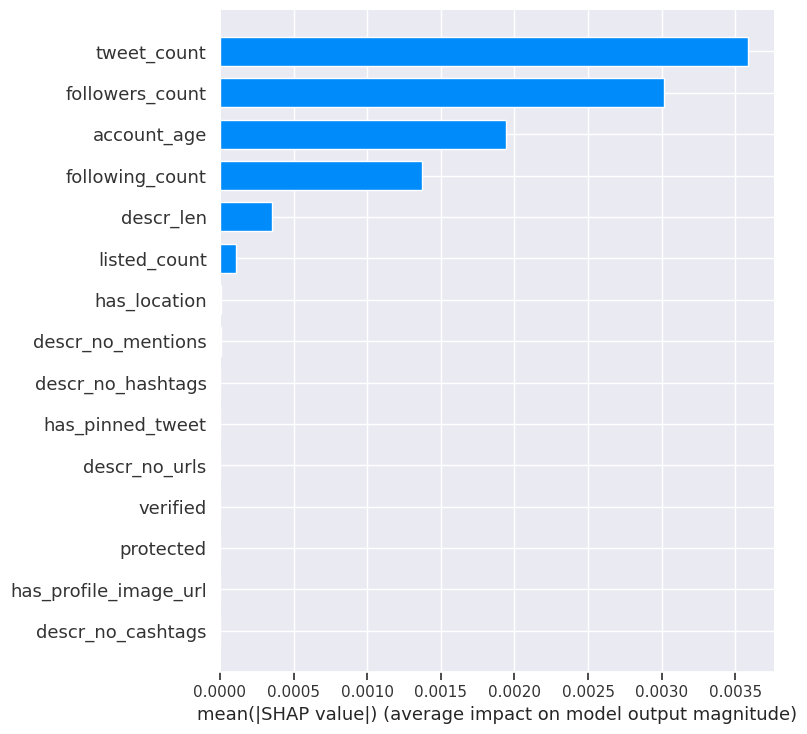

In [538]:
shap.summary_plot(shap_values[0], train_X, plot_type='bar')

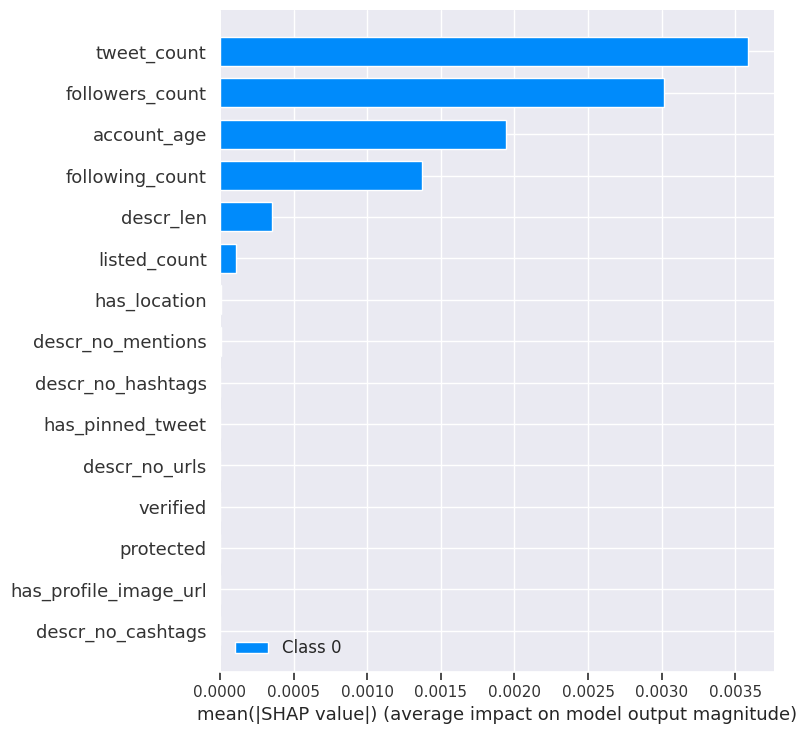

In [539]:
shap.summary_plot(shap_values, train_X, plot_type='bar')

In [540]:
# shap.dependence_plot("followers_count", shap_values[0],  train_X)

### Grid search for finding the most optimal set of parameters

In [541]:
# from sklearn.model_selection import GridSearchCV
# from scikeras.wrappers import KerasClassifier

In [542]:
# model_wrapper = KerasClassifier(model=create_model_1(shape=(train_X.shape[1],)))
# # model_wrapper.get_params().keys()

# early_stop_sg = EarlyStopping(monitor='accuracy',
#                            patience=50,
#                            restore_best_weights=True,
#                            mode='max')

# parameters = {
#     'optimizer' : [tf.keras.optimizers.Adam(learning_rate=0.0001), tf.keras.optimizers.Adam(learning_rate=0.001), tf.keras.optimizers.Adam(learning_rate=0.01)],
#     'batch_size' : [10, 20, 40, 60, 80, 100, 150, 200, 250],
#     'epochs' : [10, 50, 100],
#     'callbacks' : [early_stop_sg]}
# # parameters = {
# #     'batch_size' : [10, 20, 60, 100, 150, 200],
# #     'epochs' : [10, 50]}


# dnn_model_grid = GridSearchCV(estimator=model_wrapper,
#                         param_grid=parameters,
#                         scoring='accuracy',
#                         cv=5,
#                         n_jobs=10,
#                         verbose=0)


# dnn_model_grid.fit(train_X, train_Y)

In [543]:
# print("Best score: ", dnn_model_grid.best_score_)
# print("Best params: ", dnn_model_grid.best_params_)